# Proyek Akhir: Menyelesaikan Permasalahan Human Resources

- Nama: Danang Agung Restu Aji
- Email: danangrestuaji@gmail.com
- Id Dicoding: profdara

**tujuan dari proyek ini adalah :**
- Mencari tahu penyebab tingginya tingkat Attrition (pengunduran diri karyawan)
- Mengidentifikasi faktor utama penyebab attrition
- Analisis data dan visualisasi dalam dashboard untuk HR

## Persiapan

### Menyiapkan library yang dibutuhkan

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from xgboost import XGBClassifier
import joblib

# Utilities
import os
import warnings
warnings.filterwarnings("ignore")  # Hindari warning yang mengganggu

## Data Understanding

In [65]:
# Visualisasi default
sns.set(style="whitegrid", palette="pastel")
plt.rcParams.update({"figure.figsize": (12, 6), "axes.titlesize": 14})

# Load dataset
file_path = "employee_data.csv"
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("Data berhasil dimuat! ")
else:
    raise FileNotFoundError(f"File tidak ditemukan di path: {file_path}")

# Cek info awal
df.info()
df.describe(include='all')
df.head()



Data berhasil dimuat! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null 

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,38,NaN,Travel_Frequently,1444,Human Resources,1,4,Other,1,...,2,80,1,7,2,3,6,2,1,2
1,2,37,1.0,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,1,80,0,15,2,1,1,0,0,0
2,3,51,1.0,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,80,3,18,2,4,10,0,2,7
3,4,42,0.0,Travel_Frequently,555,Sales,26,3,Marketing,1,...,4,80,1,23,2,4,20,4,4,8
4,5,40,NaN,Travel_Rarely,1194,Research & Development,2,4,Medical,1,...,2,80,3,20,2,3,5,3,0,2


In [66]:
# cek duplikat
df.duplicated().sum()

np.int64(0)

tidak ada duplikat

In [67]:
df.Attrition.value_counts()

Attrition
0.0    879
1.0    179
Name: count, dtype: int64

attrition value menunjukan bahwa nilai 0 dan 1 biasanya digunakan untuk menunjukkan status karyawan terkait pengunduran diri atau bertahan:
- Attrition bernilai 0 = Karyawan bertahan di perusahaan, tidak mengalami pengunduran diri.
- Attrition bernilai 1 = Karyawan keluar dari perusahaan, mengalami pengunduran diri.


In [68]:
df.isna().sum()

EmployeeId                    0
Age                           0
Attrition                   412
BusinessTravel                0
DailyRate                     0
Department                    0
DistanceFromHome              0
Education                     0
EducationField                0
EmployeeCount                 0
EnvironmentSatisfaction       0
Gender                        0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 0
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
Over18                        0
OverTime                      0
PercentSalaryHike             0
PerformanceRating             0
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel              0
TotalWorkingYears             0
TrainingTimesLastYear         0
WorkLifeBalance               0
YearsAtC

ada 412 nilai kosong (bukan nol) yang perlu diisi dengan nol

In [70]:

def detect_outliers(df):
  outlier_indices = {}
  for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
    if outliers:
      outlier_indices[col] = outliers
  return outlier_indices

# Gunakan fungsi untuk mendeteksi outlier
outliers_dict = detect_outliers(df)

# Cetak hasil deteksi outlier
if outliers_dict:
  print("Outliers found:")
  for col, indices in outliers_dict.items():
    print(f"  Column '{col}': {len(indices)} outliers at indices {indices}")
else:
  print("No outliers found in numerical columns.")


Outliers found:
  Column 'Attrition': 179 outliers at indices [1, 2, 7, 11, 24, 33, 39, 44, 54, 64, 68, 80, 100, 101, 106, 109, 112, 120, 125, 133, 164, 171, 175, 184, 198, 203, 217, 228, 233, 248, 257, 259, 267, 268, 269, 280, 285, 289, 291, 298, 300, 307, 308, 326, 365, 384, 402, 403, 408, 414, 416, 419, 421, 455, 463, 465, 476, 484, 485, 489, 496, 498, 504, 520, 526, 531, 536, 543, 548, 549, 555, 557, 564, 567, 579, 580, 585, 588, 592, 604, 609, 625, 627, 636, 650, 651, 663, 664, 667, 679, 681, 686, 724, 725, 738, 744, 747, 748, 763, 773, 779, 785, 787, 794, 801, 806, 818, 829, 851, 871, 875, 876, 887, 905, 927, 930, 931, 944, 947, 950, 962, 964, 975, 986, 989, 997, 1005, 1014, 1019, 1020, 1037, 1052, 1067, 1075, 1105, 1107, 1114, 1116, 1117, 1119, 1129, 1134, 1150, 1155, 1180, 1188, 1196, 1199, 1210, 1216, 1220, 1223, 1242, 1279, 1284, 1286, 1296, 1307, 1308, 1313, 1332, 1353, 1358, 1375, 1376, 1378, 1379, 1399, 1413, 1430, 1435, 1440, 1444, 1446, 1455, 1457, 1464, 1467, 1469]
  Co

In [71]:
# Pastikan daftar kolom numerik terdefinisi
num = df.select_dtypes(include=np.number).columns

# Menyimpan hasil outlier summary outlier
outlier = []

for col in num:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    outlier_mask = ~df[col].between(low, high)
    outlier.append({
        "Kolom": col,
        "Status Outlier": outlier_mask.any(),
        "Jumlah": outlier_mask.sum(),
        "Batas Bawah": low,
        "Batas Atas": high,


    })

# Menghitung jumlah total outlier dalam dataset
combined_outlier_mask = np.all([
    df[col].between(df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)),
                    df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))
    for col in num
], axis=0)

print(f'Jumlah total baris: {len(df)}')
print("Jumlah Outlier pada Seluruh Data :", (~combined_outlier_mask).sum())
print("Jumlah Data yang Bukan Outlier :", combined_outlier_mask.sum())

# Simpan hasil analisis dalam DataFrame
outlier_summary_df = pd.DataFrame(outlier)
print(outlier_summary_df)




Jumlah total baris: 1470
Jumlah Outlier pada Seluruh Data : 1018
Jumlah Data yang Bukan Outlier : 452
                       Kolom  Status Outlier  Jumlah  Batas Bawah  Batas Atas
0                 EmployeeId           False       0     -733.500    2204.500
1                        Age           False       0       10.500      62.500
2                  Attrition            True     591        0.000       0.000
3                  DailyRate           False       0     -573.000    2195.000
4           DistanceFromHome           False       0      -16.000      32.000
5                  Education           False       0       -1.000       7.000
6              EmployeeCount           False       0        1.000       1.000
7    EnvironmentSatisfaction           False       0       -1.000       7.000
8                 HourlyRate           False       0       -5.625     137.375
9             JobInvolvement           False       0        0.500       4.500
10                  JobLevel           F

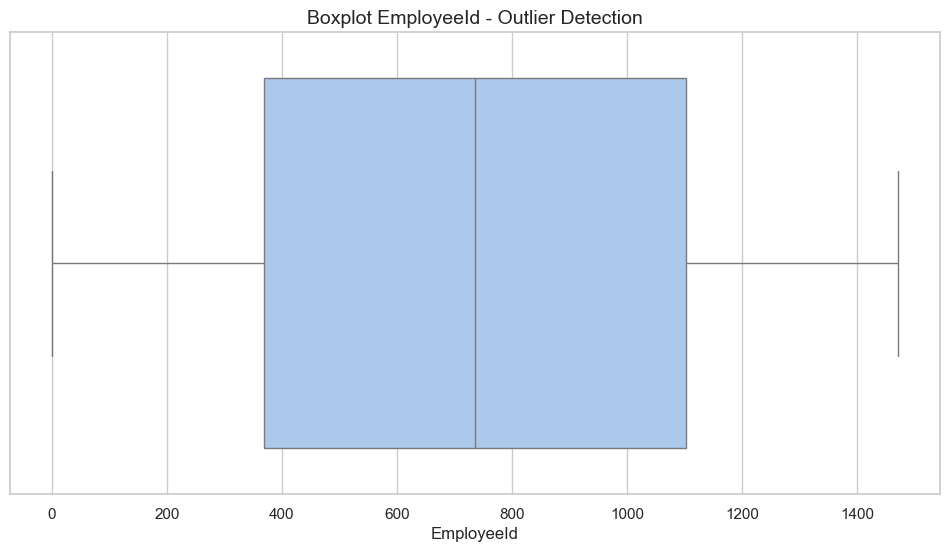

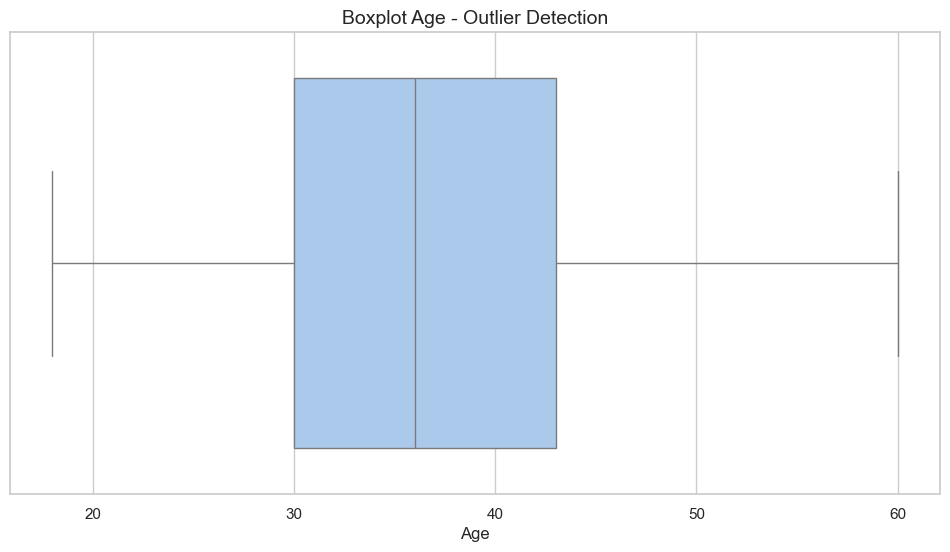

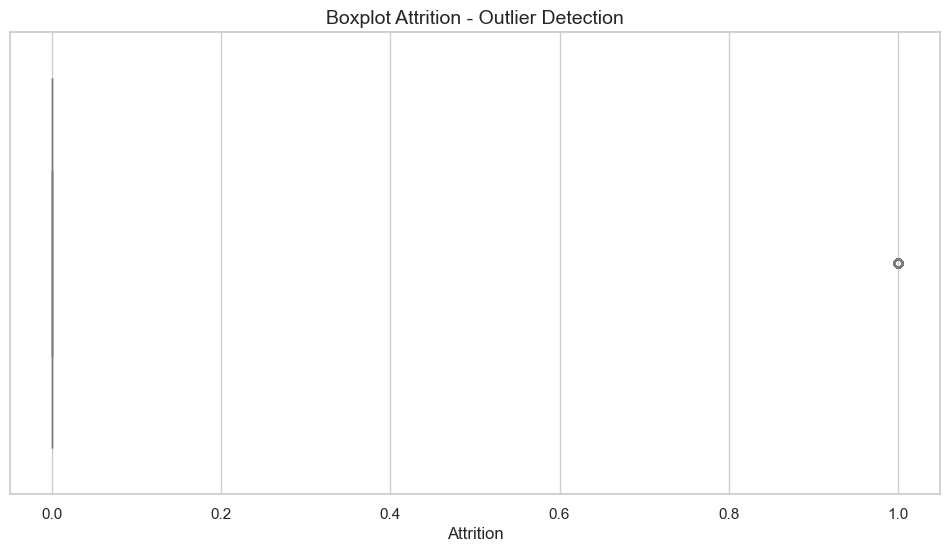

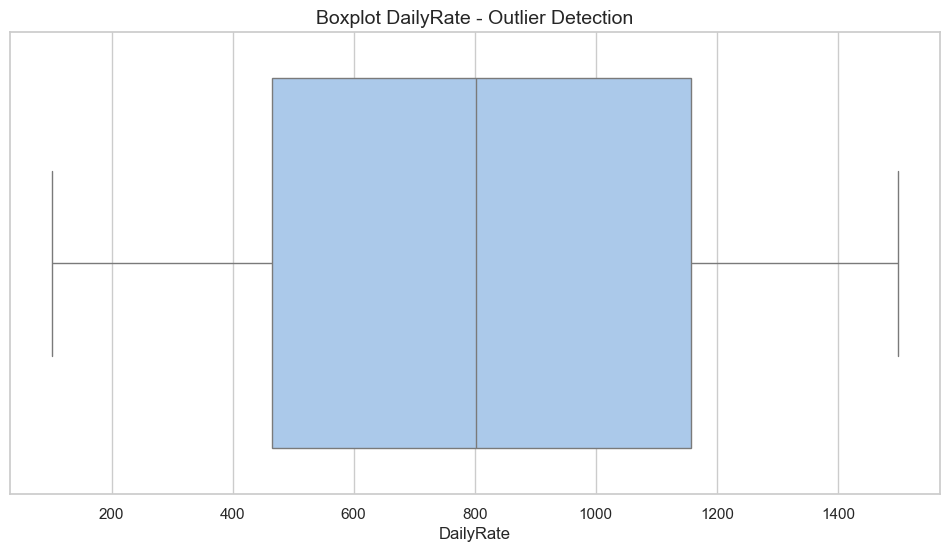

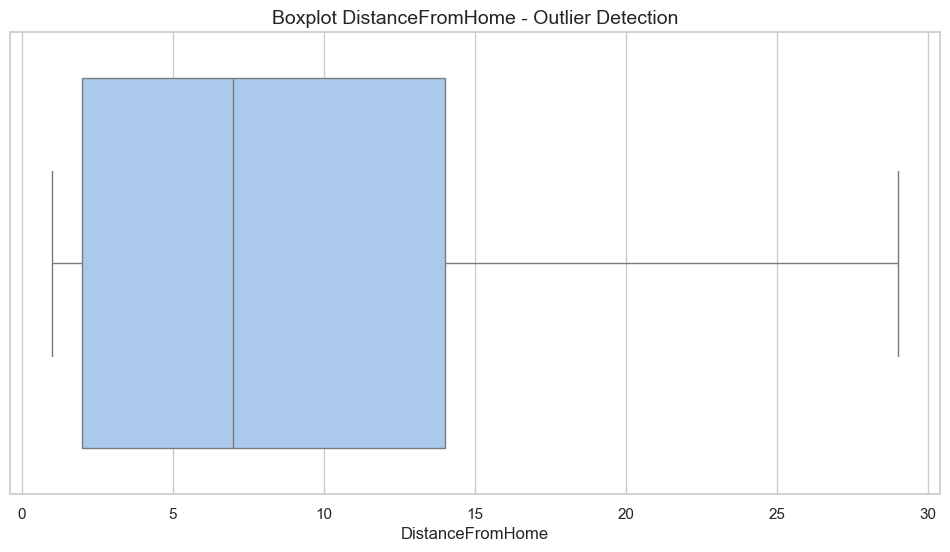

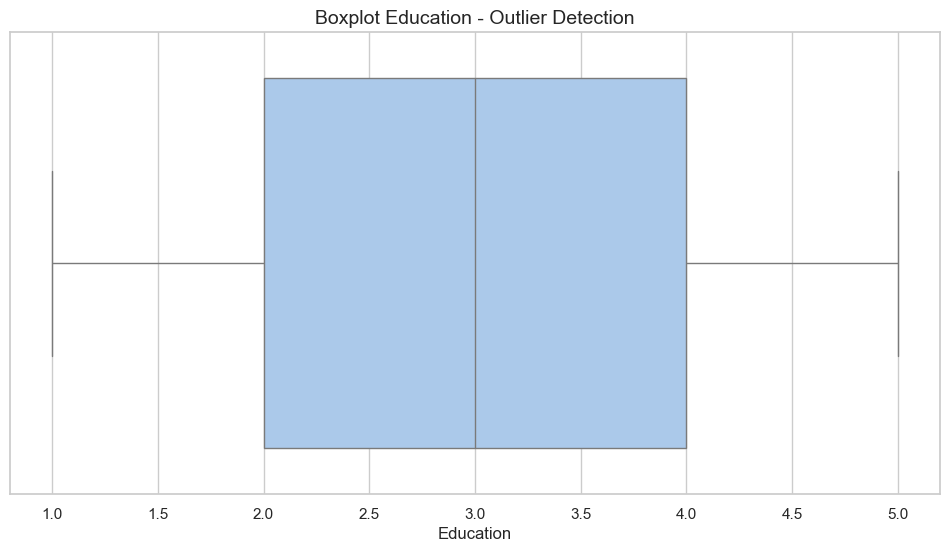

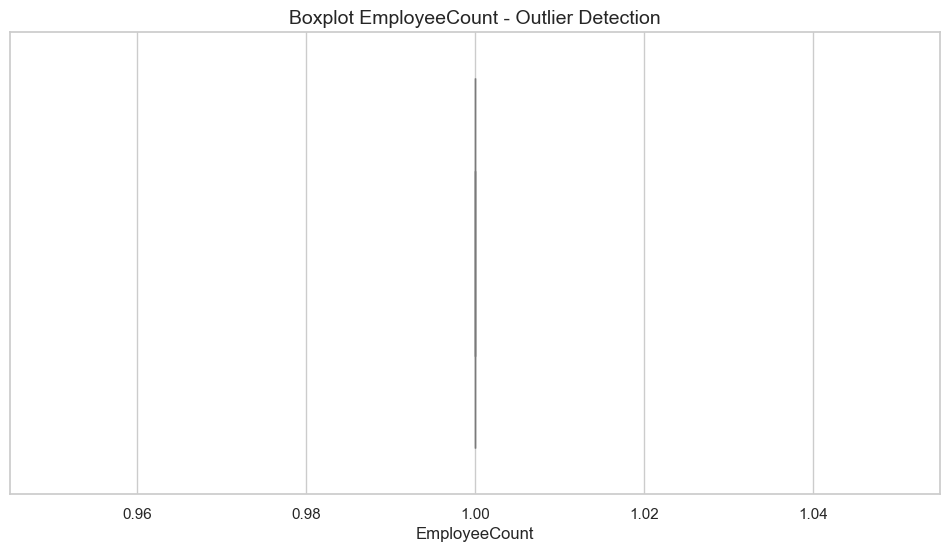

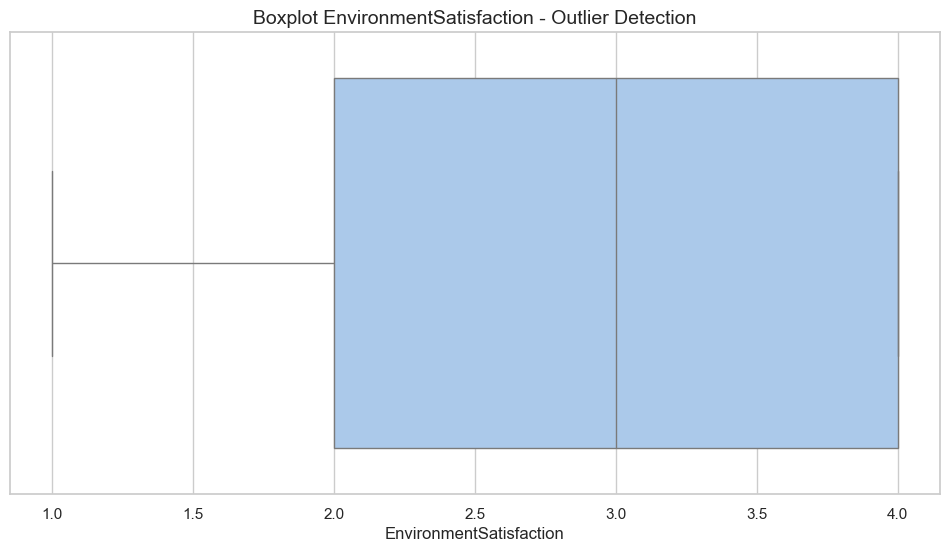

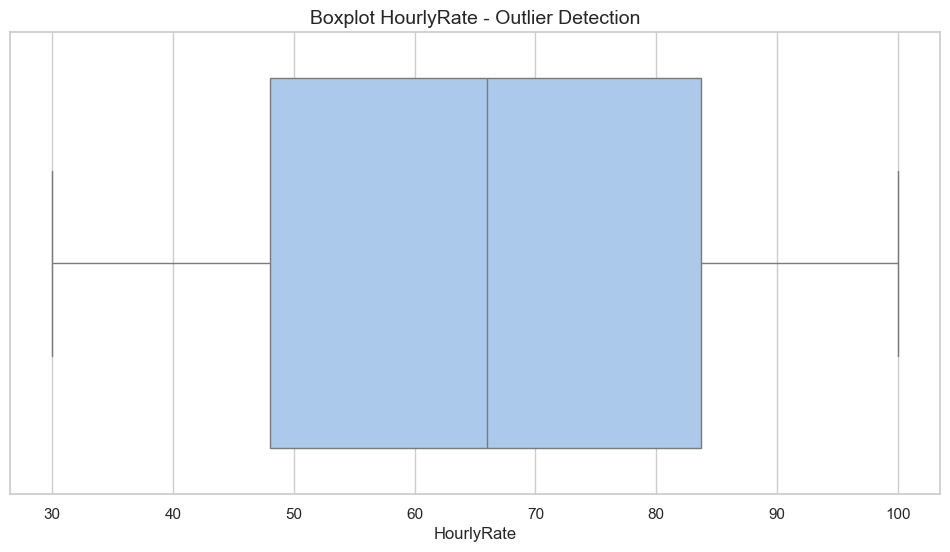

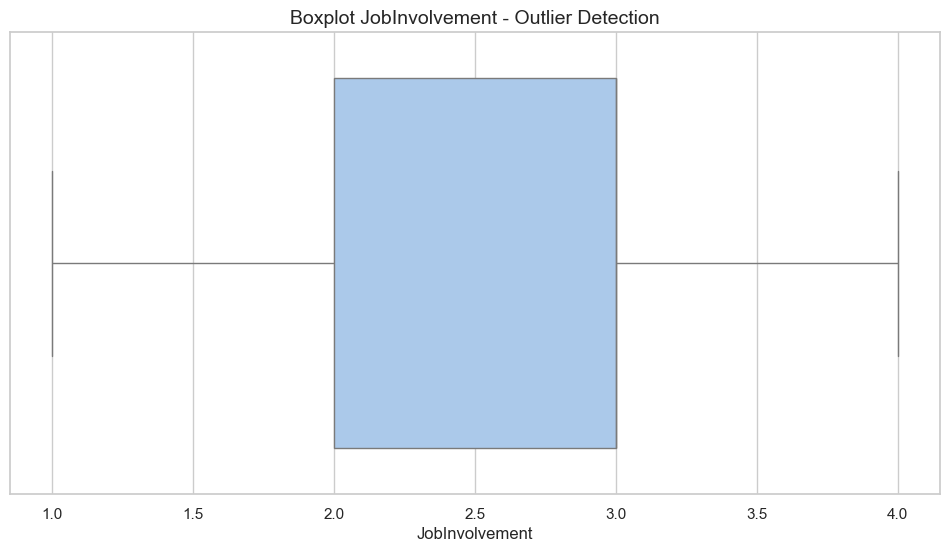

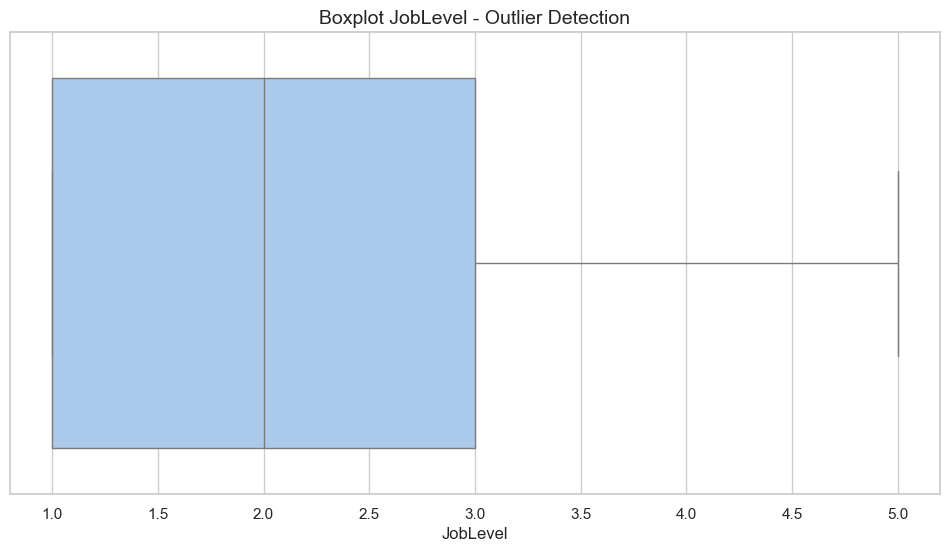

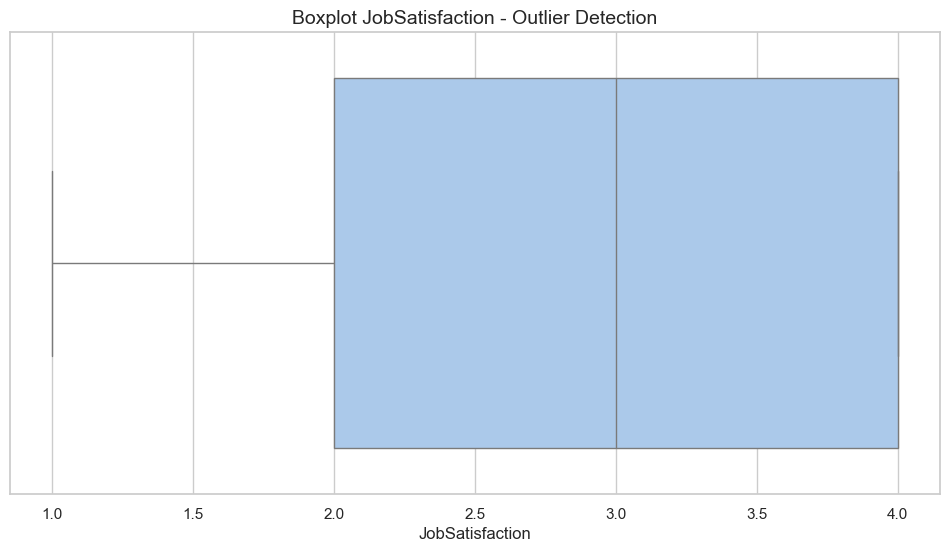

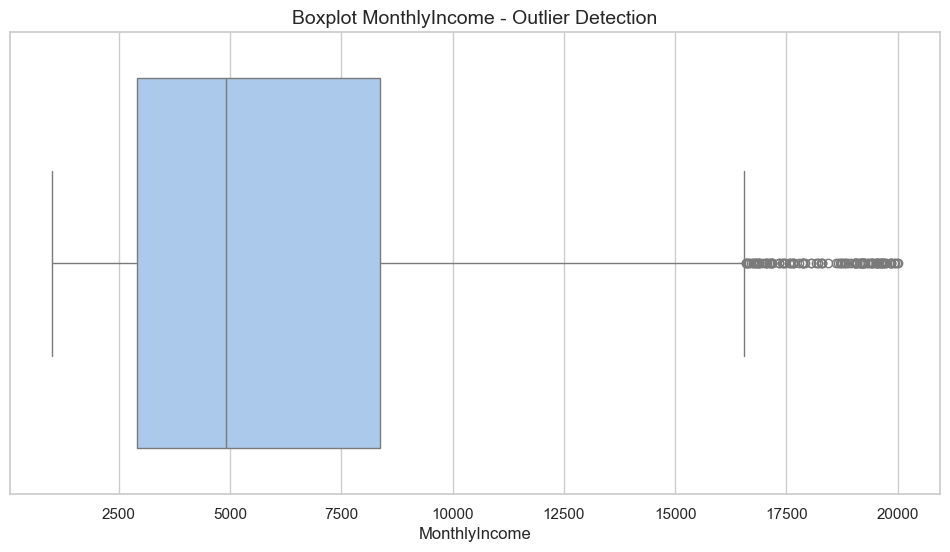

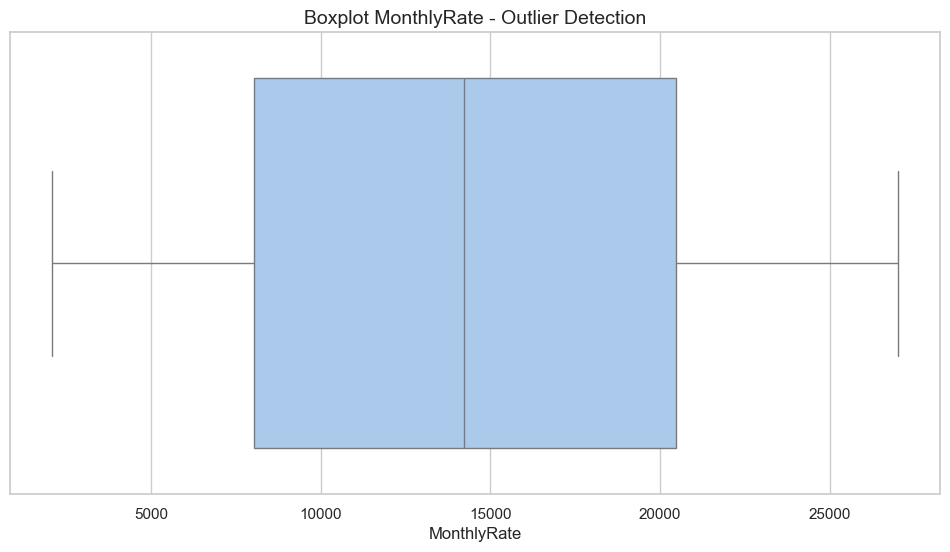

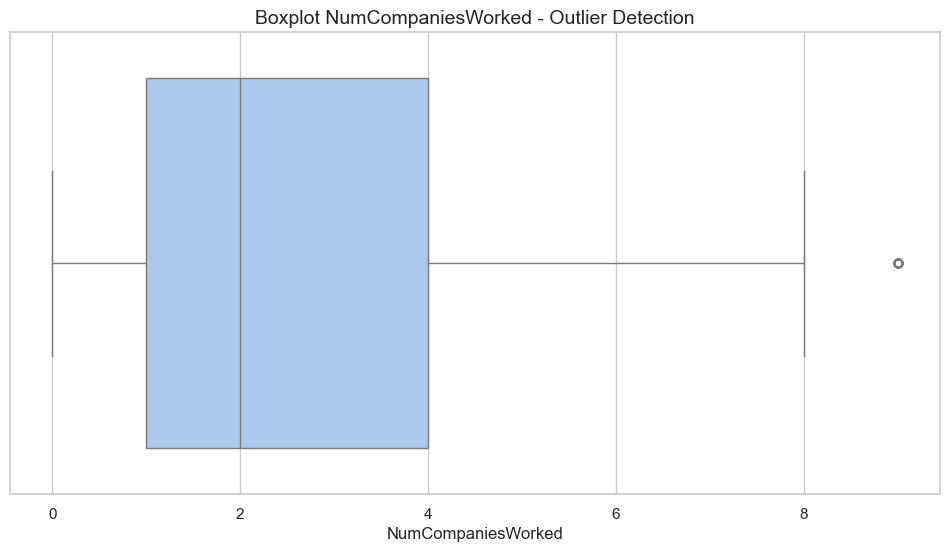

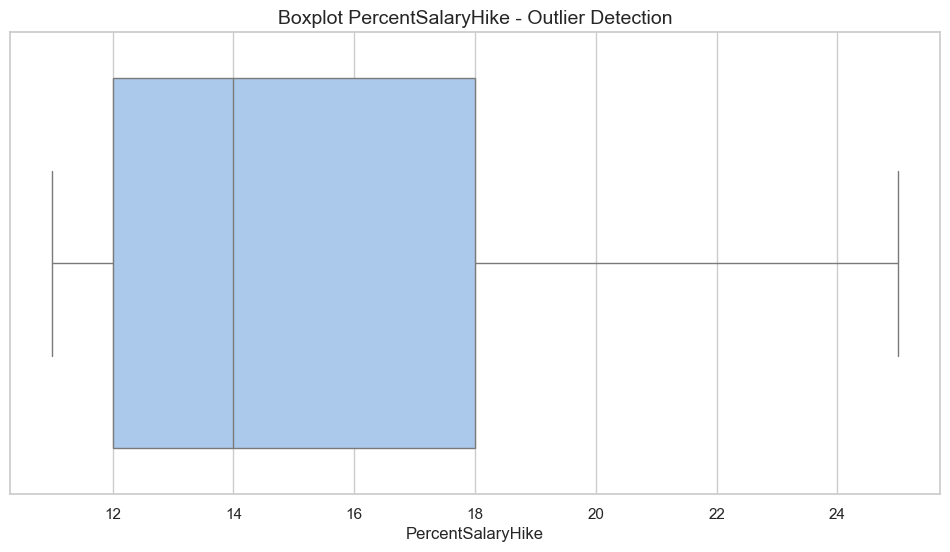

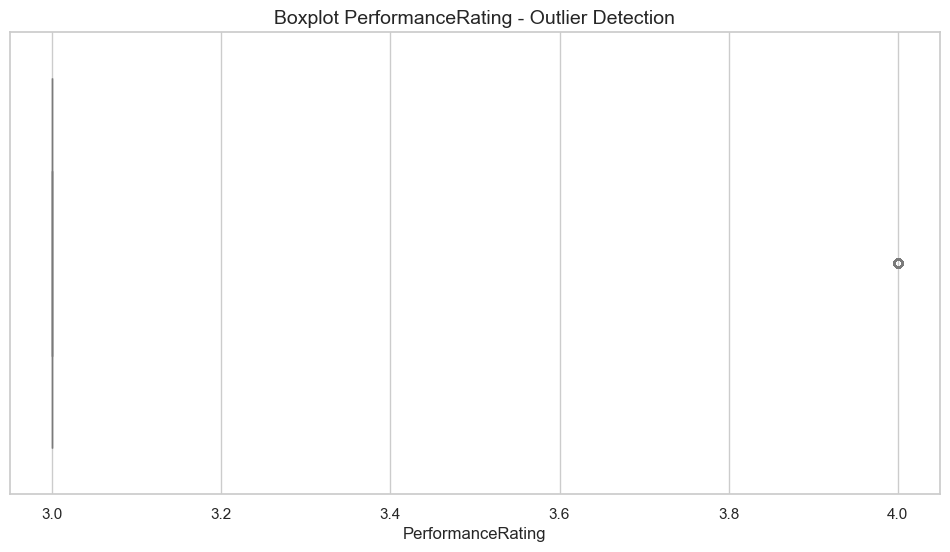

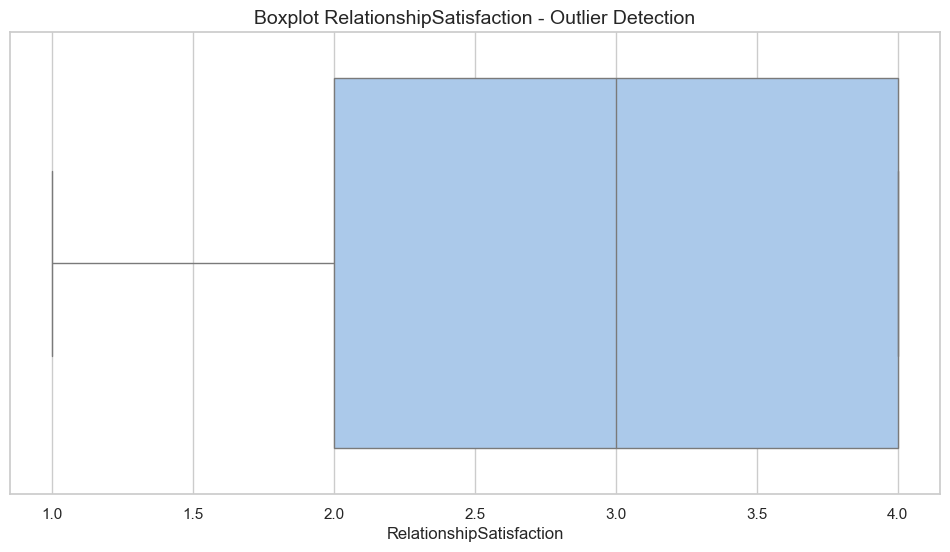

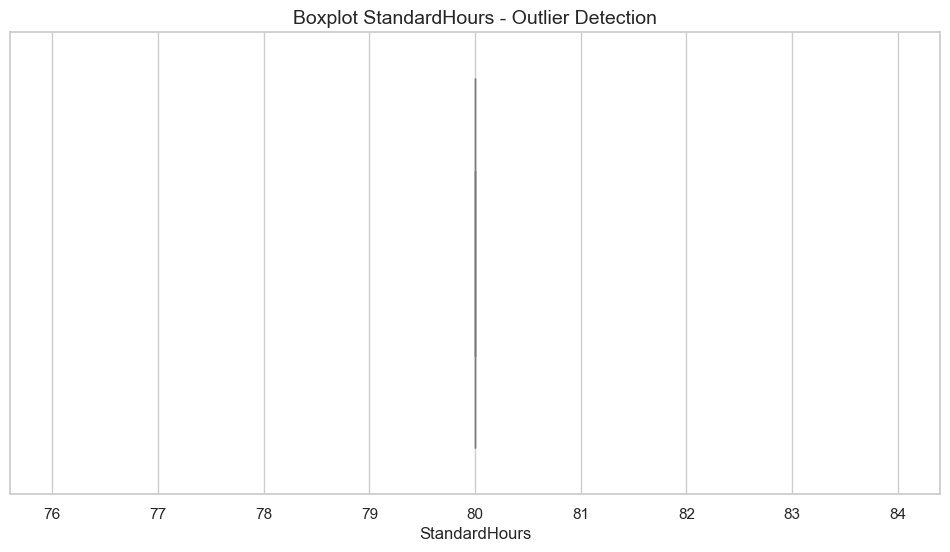

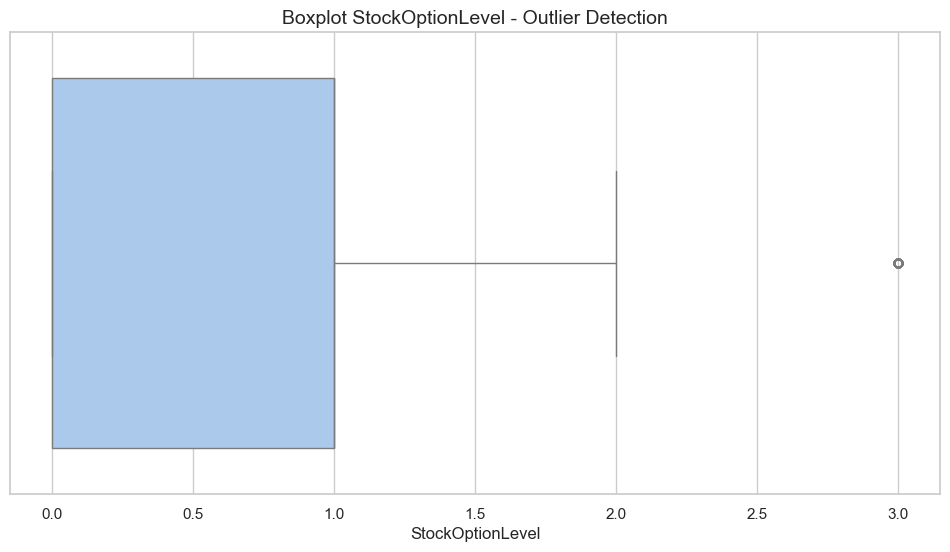

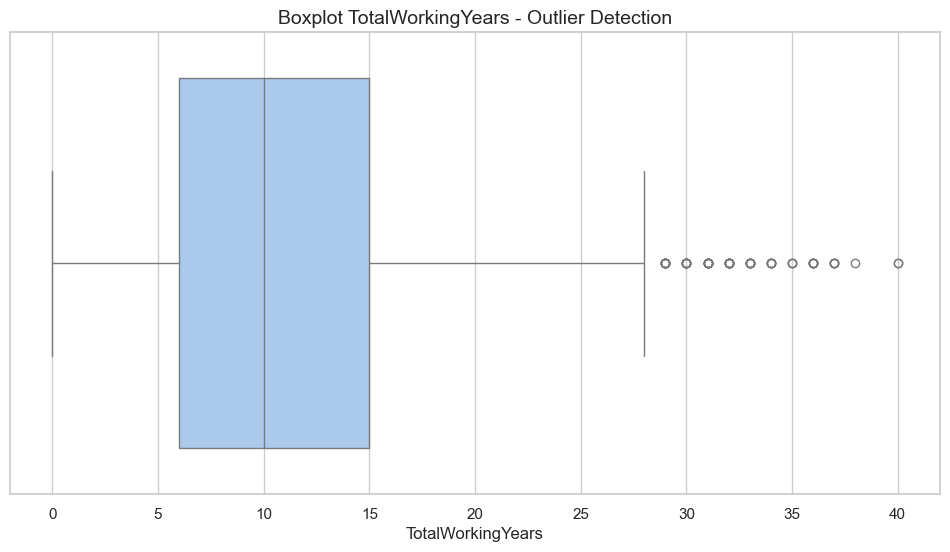

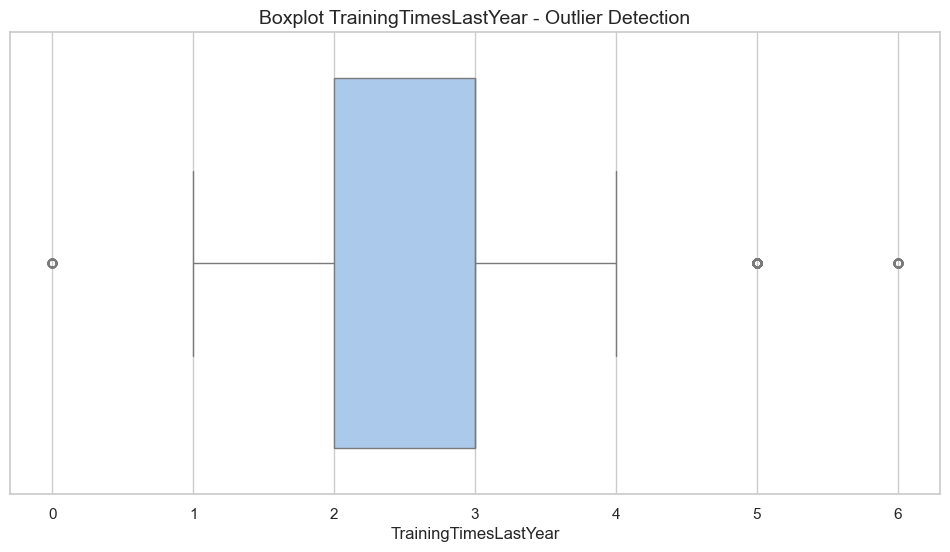

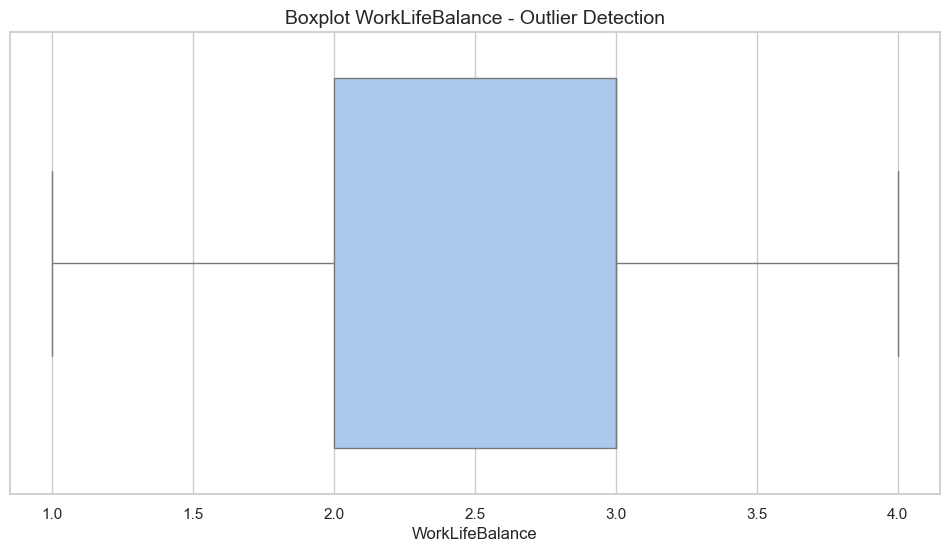

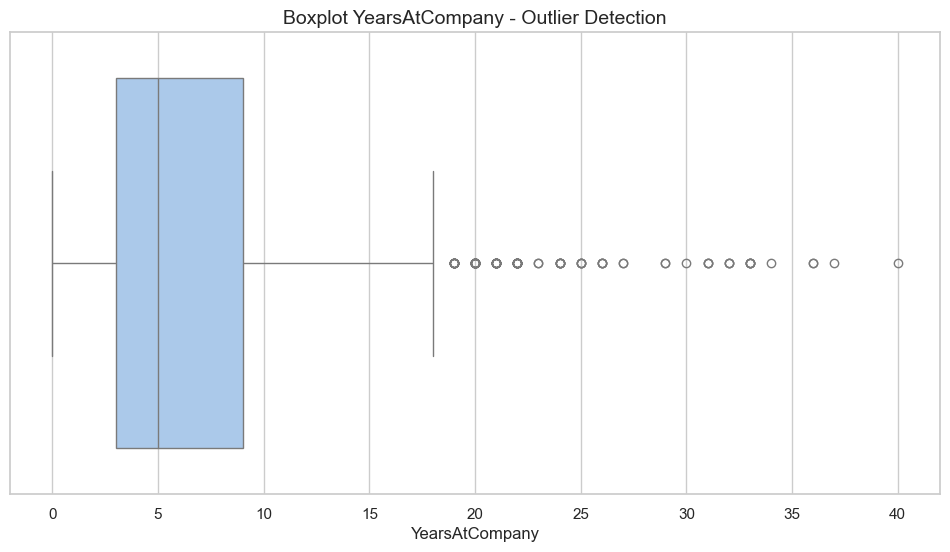

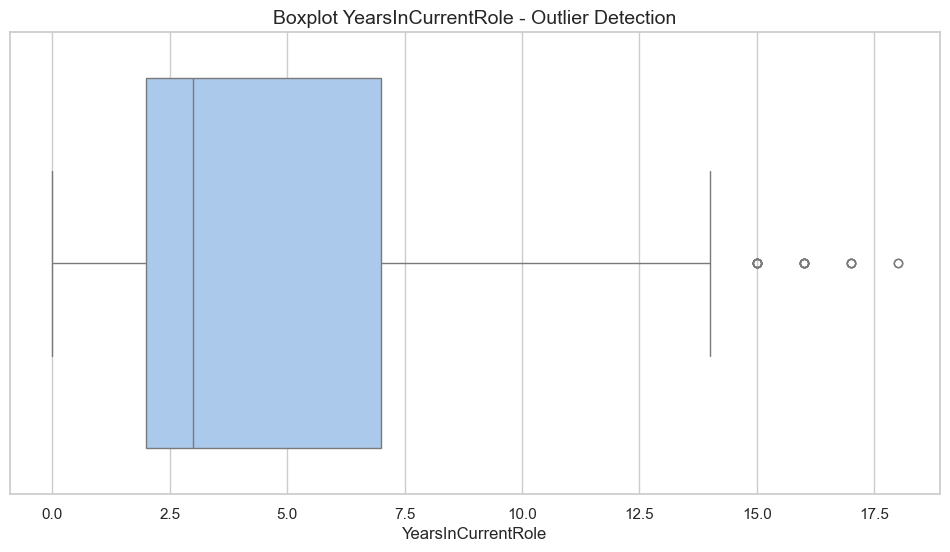

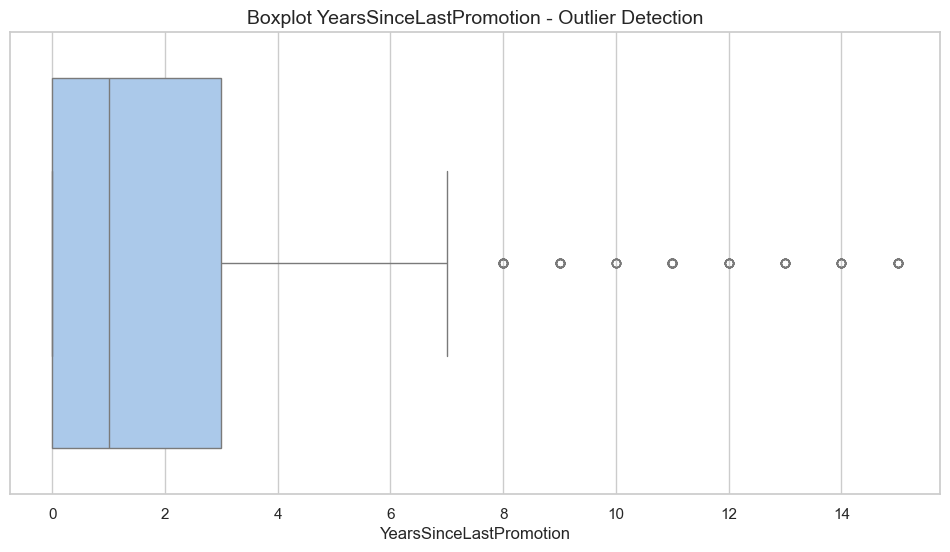

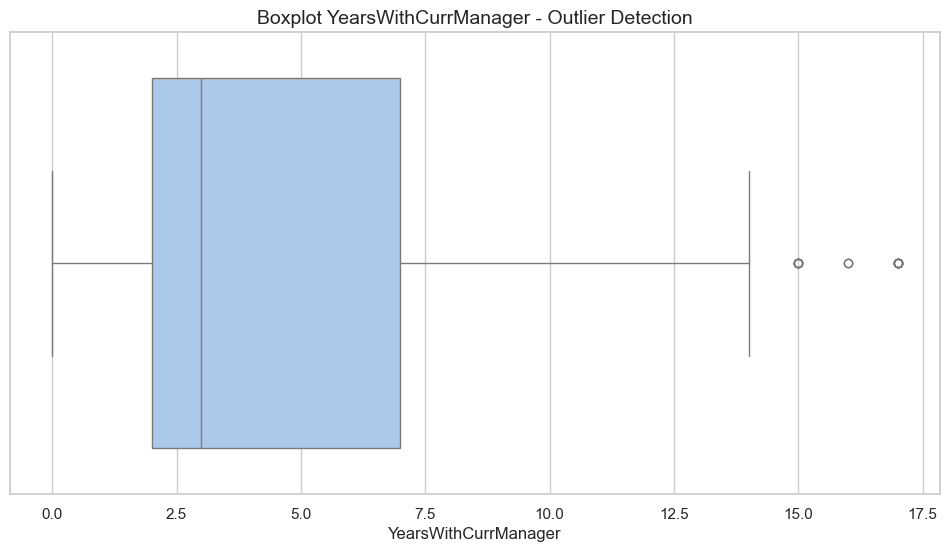

In [72]:
# Visualisasi distribusi data dengan Boxplot
for col in num:
    if col in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x=col)
        plt.title(f'Boxplot {col} - Outlier Detection')
        plt.show()

**Insight:**
- Dataset ini berisi 1.470 entri dengan 35 kolom yang mencakup berbagai aspek karyawan, termasuk demografi, pengalaman kerja, kompensasi, dan tingkat kepuasan. Berikut ini penjelasan beberapa komponen utama data yang relevan untuk analisis

# Komponen Utama dalam Data
- Attrition (Tingkat Pengunduran Diri) – Kolom target yang menunjukkan apakah karyawan telah keluar dari perusahaan atau masih bertahan.
- Age (Usia) – Bisa menjadi faktor dalam tren pengunduran diri.
- BusinessTravel (Frekuensi Perjalanan Dinas) – Pengaruh perjalanan bisnis terhadap keputusan karyawan untuk keluar.
- Department (Departemen) – Perbandingan antar-departemen untuk melihat tren pengunduran diri.
- DistanceFromHome (Jarak dari Rumah) – Bisa mempengaruhi kepuasan dan keputusan untuk bertahan.
- JobSatisfaction & WorkLifeBalance – Faktor kepuasan kerja dan keseimbangan hidup.
- MonthlyIncome & PercentSalaryHike – Komponen finansial yang mungkin memengaruhi retensi karyawan.
- YearsAtCompany & YearsSinceLastPromotion – Bisa menjadi indikator loyalitas dan kepuasan karier.

# Ada beberapa aspek yang perlu dibersihkan sebelum analisis:
- Missing Values – Kolom Attrition memiliki 1058 nilai valid dari 1470, berarti ada nilai kosong (NaN) yang perlu ditangani (bisa dengan imputasi atau penghapusan baris).
- Inconsistencies – Pastikan tidak ada kesalahan dalam kolom kategorikal seperti BusinessTravel dan Department.
- Outliers – Variabel seperti MonthlyIncome dan TotalWorkingYears perlu dicek untuk outlier yang bisa mempengaruhi analisis.
- Feature Engineering – Bisa membuat fitur baru seperti rasio kenaikan gaji terhadap masa kerja.



## Data Preparation / Preprocessing

# Data Cleaning

In [73]:
# 3. Data Cleaning
# Tangani missing value pada kolom 'Attrition'
df['Attrition'] = df['Attrition'].fillna(0) # untuk mengisi nilai yang kosong (NaN) dengan angka 0
df['Attrition'] = df['Attrition'].astype(int)

# Trim whitespaces
df.columns = df.columns.str.strip() #membersihkan data dari spasi yang tidak diinginkan dalam nama kolom dan nilai string
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Drop kolom redundan
df = df.drop(columns=['Over18', 'StandardHours', 'EmployeeCount'])

# cek info akhir
df.info()
df.describe(include='all')
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeId                1470 non-null   int64 
 1   Age                       1470 non-null   int64 
 2   Attrition                 1470 non-null   int64 
 3   BusinessTravel            1470 non-null   object
 4   DailyRate                 1470 non-null   int64 
 5   Department                1470 non-null   object
 6   DistanceFromHome          1470 non-null   int64 
 7   Education                 1470 non-null   int64 
 8   EducationField            1470 non-null   object
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,38,0,Travel_Frequently,1444,Human Resources,1,4,Other,4,...,3,2,1,7,2,3,6,2,1,2
1,2,37,1,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,3,1,0,15,2,1,1,0,0,0
2,3,51,1,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,3,3,18,2,4,10,0,2,7
3,4,42,0,Travel_Frequently,555,Sales,26,3,Marketing,3,...,3,4,1,23,2,4,20,4,4,8
4,5,40,0,Travel_Rarely,1194,Research & Development,2,4,Medical,3,...,3,2,3,20,2,3,5,3,0,2



Kolom: MonthlyIncome
Baris sebelum menangani outliers : 1470
Baris setelah menangani outliers : 1356

Kolom: NumCompaniesWorked
Baris sebelum menangani outliers : 1470
Baris setelah menangani outliers : 1418

Kolom: StockOptionLevel
Baris sebelum menangani outliers : 1470
Baris setelah menangani outliers : 1385

Kolom: TotalWorkingYears
Baris sebelum menangani outliers : 1470
Baris setelah menangani outliers : 1407

Kolom: TrainingTimesLastYear
Baris sebelum menangani outliers : 1470
Baris setelah menangani outliers : 1232

Kolom: YearsAtCompany
Baris sebelum menangani outliers : 1470
Baris setelah menangani outliers : 1366

Kolom: YearsInCurrentRole
Baris sebelum menangani outliers : 1470
Baris setelah menangani outliers : 1449

Kolom: YearsSinceLastPromotion
Baris sebelum menangani outliers : 1470
Baris setelah menangani outliers : 1363

Kolom: YearsWithCurrManager
Baris sebelum menangani outliers : 1470
Baris setelah menangani outliers : 1456

### Analisis Attrition Rate Berdasarka

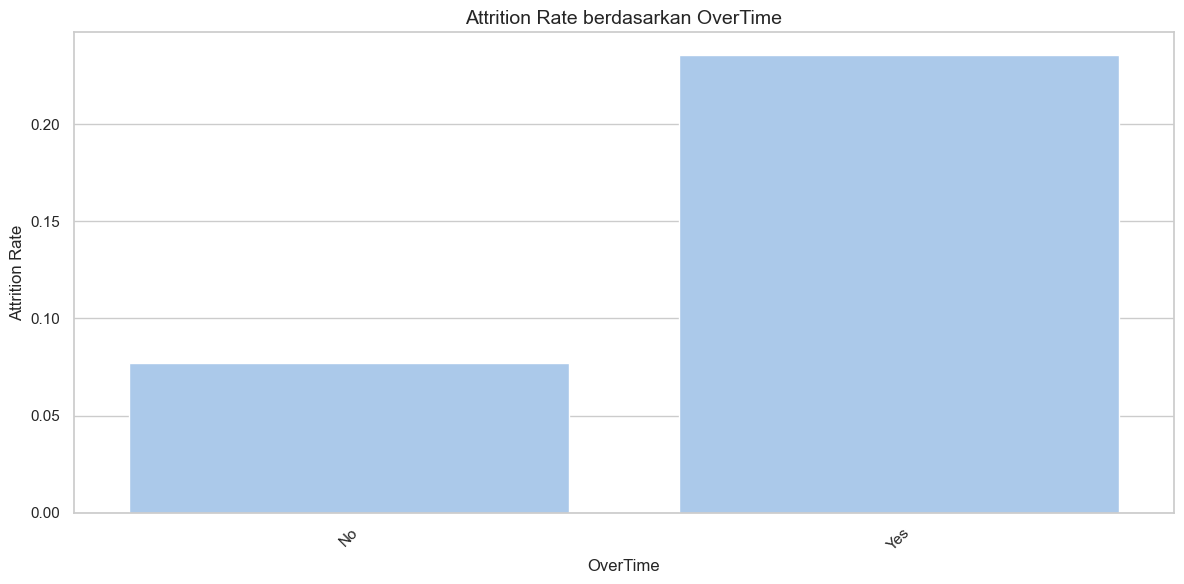

In [74]:
dfc = df.copy()
num = dfc.select_dtypes(exclude='object').columns
outlier_columns = []

for col in num:
    Q1 = dfc[col].quantile(0.25)
    Q3 = dfc[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outlier_indices = dfc[(dfc[col] < Q1 - outlier_step) | (dfc[col] > Q3 + outlier_step)].index

    if outlier_indices.any():
        outlier_columns.append(col)

cols_to_handle = [col for col in outlier_columns if col not in ['Attrition', 'PerformanceRating']]

for col in cols_to_handle:
    Q1 = dfc[col].quantile(0.25)
    Q3 = dfc[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    dfo = dfc[(dfc[col] >= lower_limit) & (dfc[col] <= upper_limit)]
    print(f"\nKolom: {col}")
    print('Baris sebelum menangani outliers :', dfc.shape[0])
    print('Baris setelah menangani outliers :', dfo.shape[0])

# Simpan dataset hasil cleaning sederhana
dfc.to_csv("cleaned_dataset.csv", index=False)

# --- Analisis Attrition Rate Berdasarkan Kategori ---
print("\n### Analisis Attrition Rate Berdasarkan Kategori ###")

def plot_attrition_rate(group_col: str, title: str, xlabel: str):
    attrition_rate = dfc.groupby(group_col)["Attrition"].mean()
    print(f"\nAttrition Rate berdasarkan {xlabel}:")
    print(attrition_rate)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=attrition_rate.index, y=attrition_rate.values)
    plt.title(title)
    plt.ylabel("Attrition Rate")
    plt.xlabel(xlabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_attrition_rate("OverTime", "Attrition Rate berdasarkan OverTime", "OverTime")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeId                1470 non-null   int64 
 1   Age                       1470 non-null   int64 
 2   Attrition                 1470 non-null   int64 
 3   BusinessTravel            1470 non-null   object
 4   DailyRate                 1470 non-null   int64 
 5   Department                1470 non-null   object
 6   DistanceFromHome          1470 non-null   int64 
 7   Education                 1470 non-null   int64 
 8   EducationField            1470 non-null   object
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

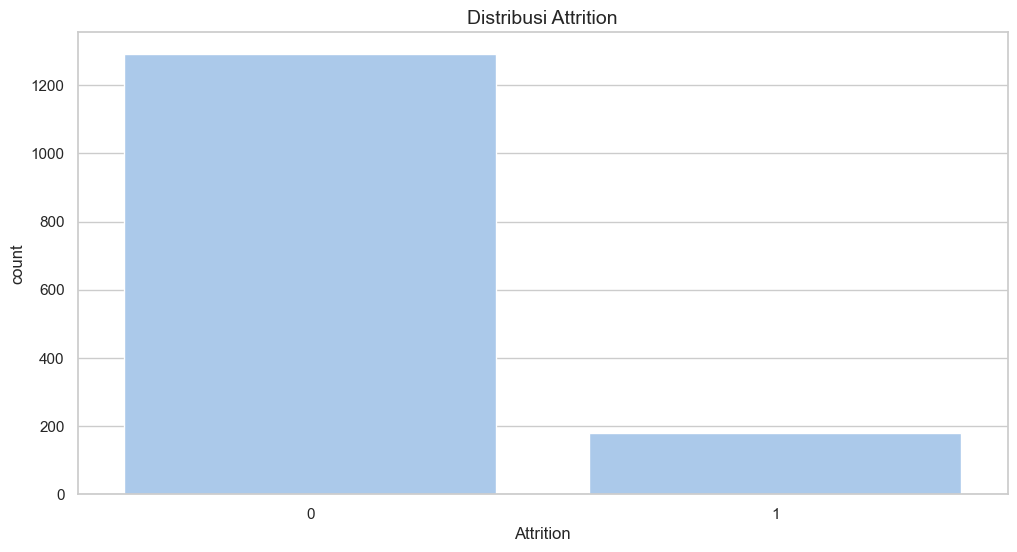

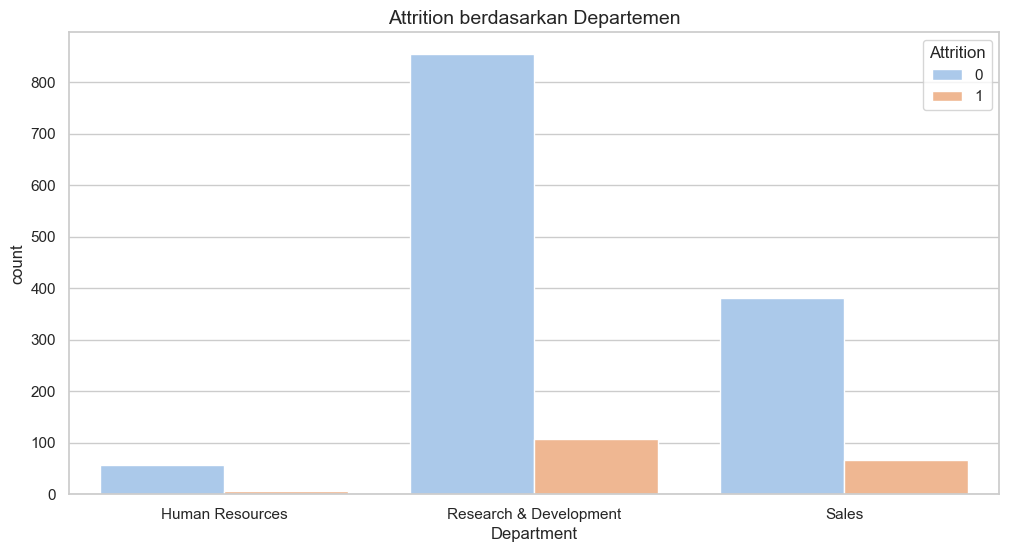

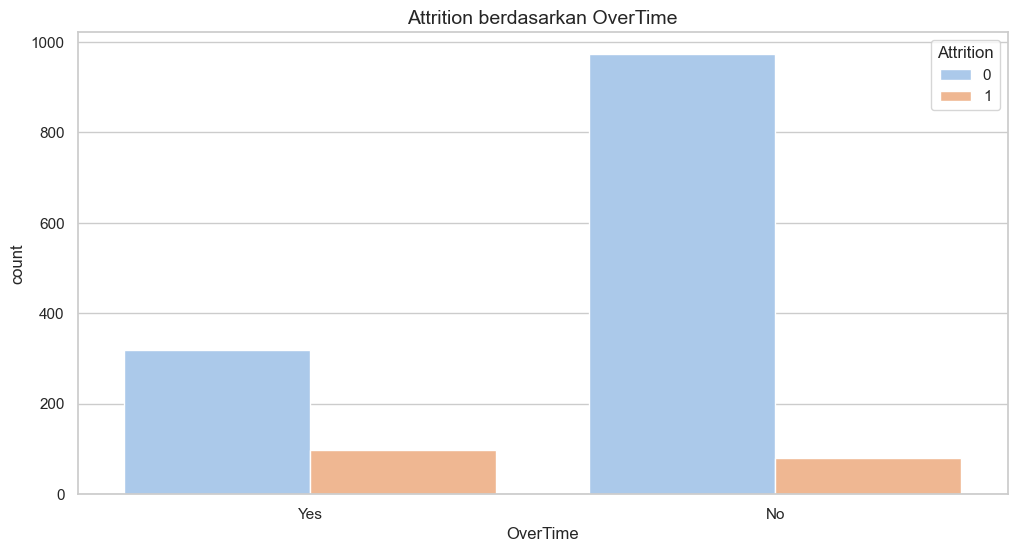

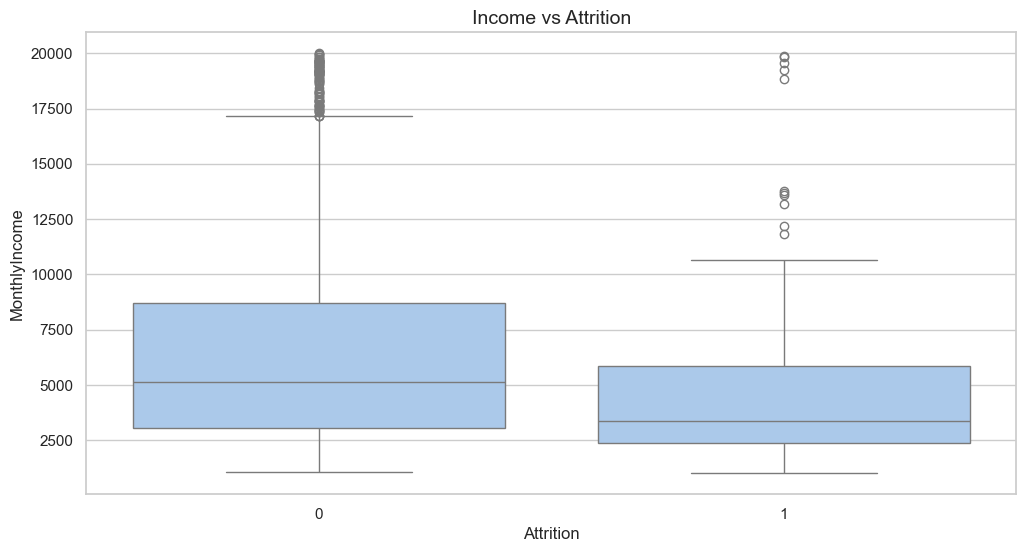

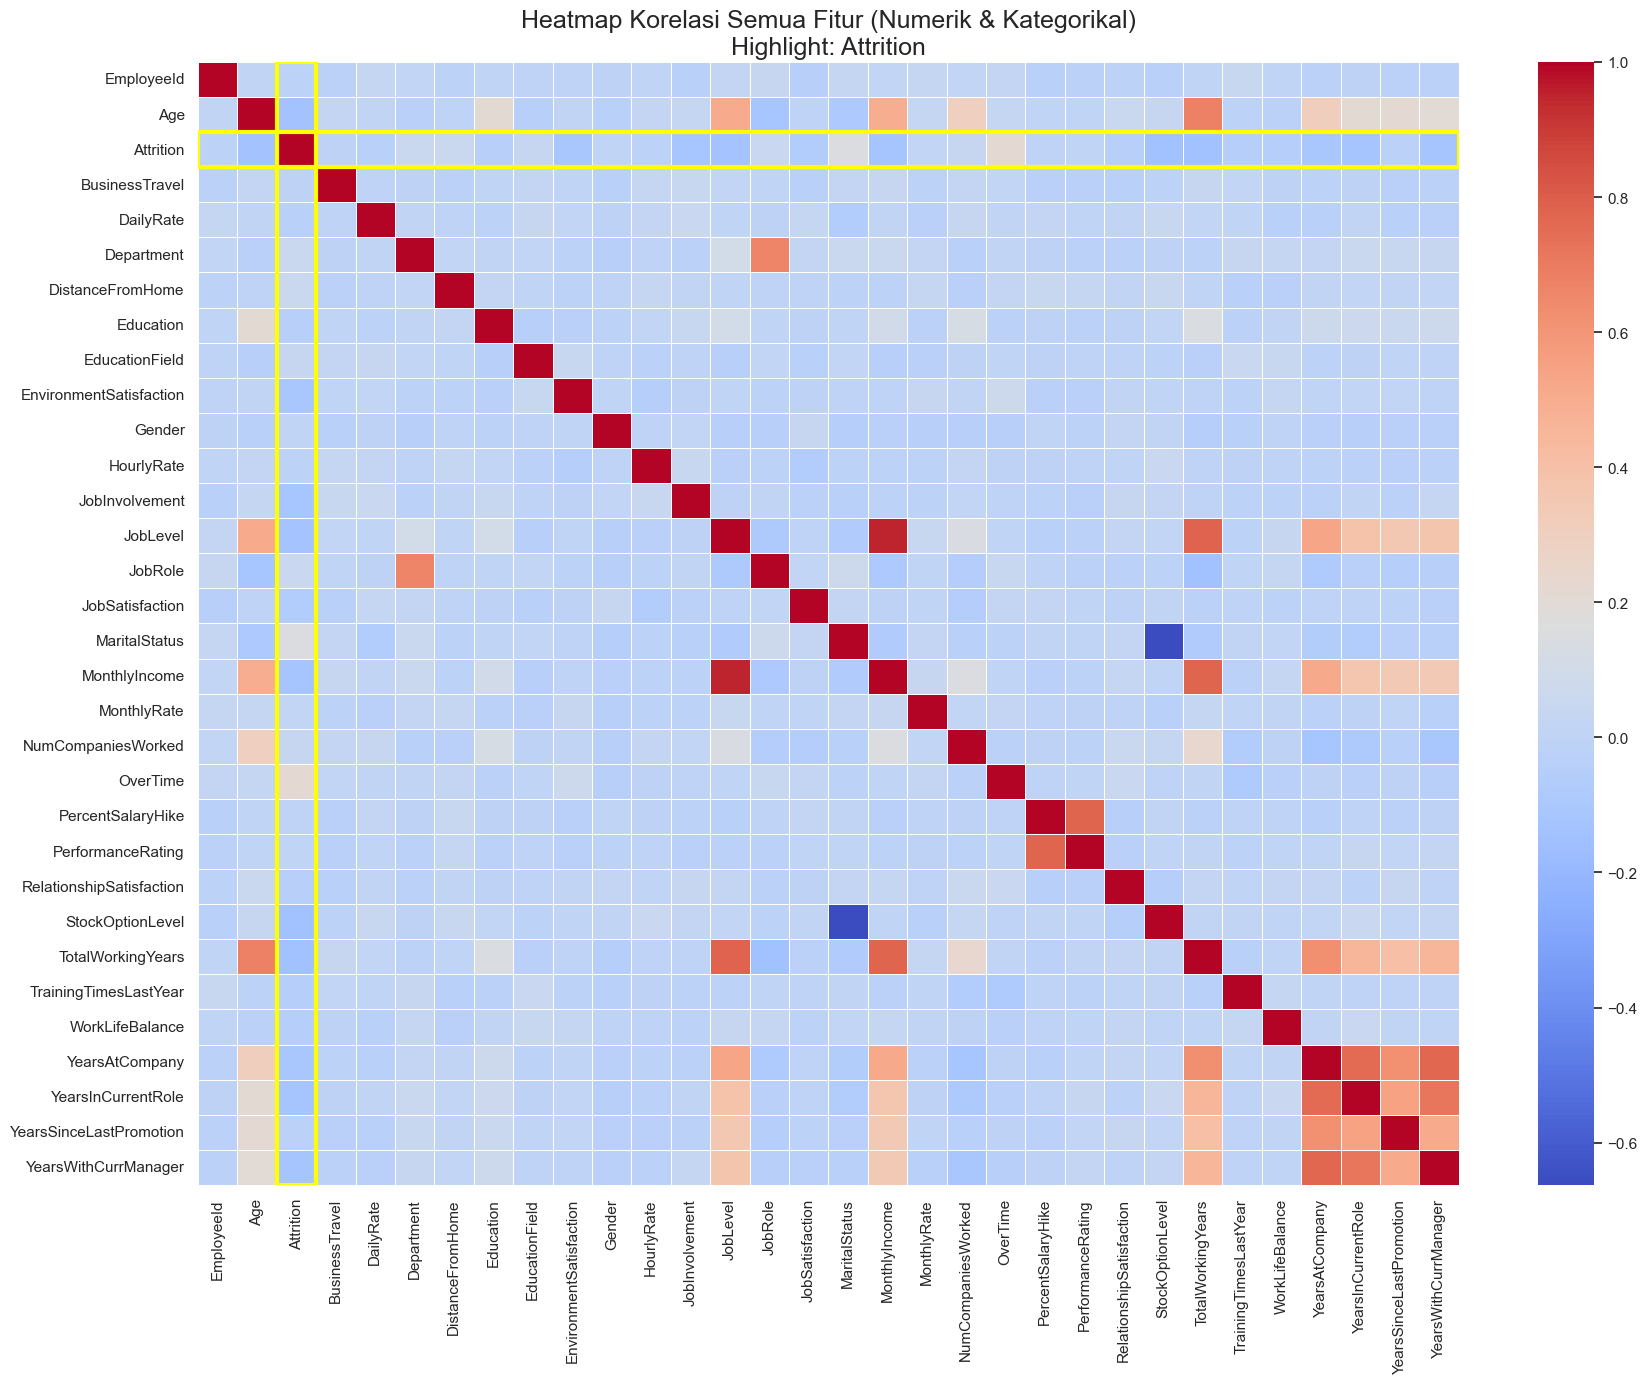


Keterangan Fitur:
EmployeeId, Age, Attrition, BusinessTravel, DailyRate, Department, DistanceFromHome, Education, EducationField, EnvironmentSatisfaction, Gender, HourlyRate, JobInvolvement, JobLevel, JobRole, JobSatisfaction, MaritalStatus, MonthlyIncome, MonthlyRate, NumCompaniesWorked, OverTime, PercentSalaryHike, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, TotalWorkingYears, TrainingTimesLastYear, WorkLifeBalance, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion



In [75]:
# Load cleaned dataset
dfc = pd.read_csv("cleaned_dataset.csv")
dfc.info()
dfc.describe(include='all')
dfc.head()

# Distribusi target
sns.countplot(data=dfc, x='Attrition')
plt.title('Distribusi Attrition')
plt.show()

# Visualisasi hubungan
sns.countplot(data=dfc, x='Department', hue='Attrition')
plt.title('Attrition berdasarkan Departemen')
plt.show()

sns.countplot(data=dfc, x='OverTime', hue='Attrition')
plt.title('Attrition berdasarkan OverTime')
plt.show()

sns.boxplot(data=dfc, x='Attrition', y='MonthlyIncome')
plt.title('Income vs Attrition')
plt.show()

# Korelasi antar semua fitur (termasuk kategorikal dengan encoding)
# Encode semua kolom kategorikal agar bisa dihitung korelasinya
dfc_encoded = dfc.copy()
for col in dfc_encoded.select_dtypes(include='object').columns:
    dfc_encoded[col] = dfc_encoded[col].astype('category').cat.codes

# Korelasi semua fitur
corr_all = dfc_encoded.corr()

plt.figure(figsize=(18, 14))
# Highlight kolom/row 'Attrition' dengan warna berbeda
mask = np.zeros_like(corr_all, dtype=bool)
attr_idx = corr_all.columns.get_loc('Attrition')
mask[attr_idx, :] = True
mask[:, attr_idx] = True

sns.heatmap(
    corr_all, 
    annot=False, 
    cmap="coolwarm", 
    cbar=True,
    linewidths=0.5,
    mask=None
)
# Highlight baris dan kolom 'Attrition'
plt.gca().add_patch(plt.Rectangle((attr_idx, 0), 1, corr_all.shape[0], fill=False, edgecolor='yellow', lw=3))
plt.gca().add_patch(plt.Rectangle((0, attr_idx), corr_all.shape[1], 1, fill=False, edgecolor='yellow', lw=3))
plt.title('Heatmap Korelasi Semua Fitur (Numerik & Kategorikal)\nHighlight: Attrition', fontsize=18)
plt.tight_layout()
plt.show()

# Keterangan fitur:
print("""
Keterangan Fitur:
EmployeeId, Age, Attrition, BusinessTravel, DailyRate, Department, DistanceFromHome, Education, EducationField, EnvironmentSatisfaction, Gender, HourlyRate, JobInvolvement, JobLevel, JobRole, JobSatisfaction, MaritalStatus, MonthlyIncome, MonthlyRate, NumCompaniesWorked, OverTime, PercentSalaryHike, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, TotalWorkingYears, TrainingTimesLastYear, WorkLifeBalance, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion
""")



#
- Dari heatmap terlihat bahwa Attrition memiliki korelasi positif denganOverTime dan MaritalStatus, dan korelasi negatif lemah dengan beberapa fitur utama, seperti Age, EnvironmentSatisfaction, JobInvolvement, JobLevel, MonthlyIncome, TotalWorkingYears, YearsAtCompany, YearsInCurrentRole, dan YearsWithCurrManager.
- Karyawan dengan usia lebih tua cenderung memiliki tingkat pengunduran diri lebih rendah , Korelasi negatif antara Age dan Attrition menunjukkan bahwa karyawan yang lebih tua cenderung bertahan lebih lama di perusahaan.
- Kepuasan kerja dan lingkungan berpengaruh , Korelasi negatif pada EnvironmentSatisfaction, JobSatisfaction, dan RelationshipSatisfaction menunjukkan bahwa kepuasan kerja yang lebih tinggi bisa mengurangi kemungkinan attrition.
- Pendapatan dan level jabatan berperan dalam retensi, MonthlyIncome dan JobLevel menunjukkan bahwa semakin tinggi pendapatan dan level jabatan, semakin kecil kemungkinan seseorang keluar.
- Lama bekerja dan hubungan dengan manajer bisa menjadi faktor, Korelasi negatif pada YearsAtCompany, YearsWithCurrManager, dan YearsSinceLastPromotion menunjukkan bahwa semakin lama seseorang bekerja atau semakin dekat dengan manajer, semakin kecil kemungkinan mereka keluar.
- Training dan work-life balance memiliki pengaruh kecil, Korelasi TrainingTimesLastYear dan WorkLifeBalance terhadap attrition tergolong lemah, artinya faktor ini tidak terlalu signifikan dalam memengaruhi keputusan keluar.


## Modeling

In [78]:
# Labeling fitur pada dfc
def label_column(dfv, fitur_list):
    dfv = dfv.copy()
    for fitur in fitur_list:
        if fitur == "Attrition":
            dfv[fitur] = dfv[fitur].map({0: "Karyawan Bertahan", 1: "Karyawan Keluar"})
        elif fitur == "JobLevel":
            dfv[fitur] = dfv[fitur].map({
                1: "Entry Level",
                2: "Junior",
                3: "Intermediate",
                4: "Senior",
                5: "Manager/Director"
            })
        elif fitur == "Education":
            dfv[fitur] = dfv[fitur].map({
                1: "Below College",
                2: "College",
                3: "Bachelor",
                4: "Master",
                5: "Doctor"
            })
        elif fitur == "WorkLifeBalance":
            dfv[fitur] = dfv[fitur].map({
                1: "Low",
                2: "Fair",
                3: "Good",
                4: "Excellent"
            })
        elif fitur in ["YearsAtCompany", "YearsWithCurrManager"]:
            dfv[fitur] = pd.cut(
                dfv[fitur],
                bins=[-1, 5, 10, 20, float('inf')],
                labels=["0-5 years", "6-10 years", "11-20 years", ">20 years"]
            )
        elif fitur == "DistanceFromHome":
            dfv[fitur] = pd.cut(
                dfv[fitur],
                bins=[-1, 5, 10, 15, 20, float('inf')],
                labels=["0-5 km", "6-10 km", "11-15 km", "16-20 km", ">20 km"]
            )
        elif fitur == "PercentSalaryHike":
            dfv[fitur] = pd.cut(
                dfv[fitur],
                bins=[-1, 10, 15, 20, 25, float('inf')],
                labels=["<=10%", "11-15%", "16-20%", "21-25%", ">25%"]
            )
        elif fitur == "Age":
            # Label umur sesuai rentang
            dfv[fitur] = pd.cut(
                dfv[fitur],
                bins=[-1, 25, 30, 35, 40, 45, 50, 60, float('inf')],
                labels=["<=25", "26-30", "31-35", "36-40", "41-45", "46-50", "51-60", ">60"]
            )
        elif fitur == "PerformanceRating":
            dfv[fitur] = dfv[fitur].map({
                1: "Low",
                2: "Good",
                3: "Excellent",
                4: "Outstanding"
            })
        elif fitur == "StockOptionLevel":
            dfv[fitur] = dfv[fitur].map({
                0: "Tidak Ada Opsi Saham",
                1: "Opsi Saham Rendah",
                2: "Opsi Saham Sedang",
                3: "Opsi Saham Tinggi"
            })
        elif fitur == "EnvironmentSatisfaction":
            dfv[fitur] = dfv[fitur].map({
                1: "Tidak Puas",
                2: "Cukup Puas",
                3: "Puas",
                4: "Sangat Puas"
            })
        elif fitur == "JobInvolvement":
            dfv[fitur] = dfv[fitur].map({
                1: "Rendah",
                2: "Sedang",
                3: "Tinggi",
                4: "Sangat Tinggi"
            })
        elif fitur == "JobSatisfaction":
            dfv[fitur] = dfv[fitur].map({
                1: "Tidak Puas",
                2: "Cukup Puas",
                3: "Puas",
                4: "Sangat Puas"
            })
        elif fitur == "RelationshipSatisfaction":
            dfv[fitur] = dfv[fitur].map({
                1: "Tidak Puas",
                2: "Cukup Puas",
                3: "Puas",
                4: "Sangat Puas"
            })
        elif fitur == "TrainingTimesLastYear":
            dfv[fitur] = dfv[fitur].map({
                0: "Tidak Pernah",
                1: "1x",
                2: "2x",
                3: "3x",
                4: "4x",
                5: "5x",
                6: "6x"
            })
        else:
            # Default: jika skala 1-4, beri label umum
            dfv[fitur] = dfv[fitur].map({
                1: "Low",
                2: "Medium",
                3: "High",
                4: "Very High"
            })
    return dfv

# Daftar fitur yang ingin diberi label
fitur_to_label = [
    "Attrition", "JobLevel", "Education", "WorkLifeBalance", "YearsAtCompany",
    "YearsWithCurrManager", "DistanceFromHome", "PercentSalaryHike", "Age",
    "PerformanceRating", "EnvironmentSatisfaction", "JobInvolvement",
    "JobSatisfaction", "RelationshipSatisfaction", "TrainingTimesLastYear"
]

# Terapkan labeling pada seluruh fitur yang diinginkan
dfc_labeled = label_column(dfc.copy(), fitur_to_label)
dfc_labeled.head()

# Simpan data yang sudah terlabel ke file Excel
dfc_labeled.to_excel("employee_data_labeled.xlsx", index=False)
print("Data terlabel berhasil disimpan ke 'employee_data_labeled.xlsx'")

Data terlabel berhasil disimpan ke 'employee_data_labeled.xlsx'


### Penjelasan Fungsi `label_column`

Fungsi `label_column` digunakan untuk memberikan label kategorikal pada berbagai fitur numerik dalam dataset karyawan, agar lebih mudah dibaca dan dianalisis. Label diberikan berdasarkan nilai masing-masing fitur, seperti:

- **Attrition**: Mengklasifikasikan status karyawan sebagai "Karyawan Bertahan" atau "Karyawan Keluar".
- **JobLevel & Education**: Mengubah level menjadi nama tingkat yang lebih deskriptif.
- **WorkLifeBalance, JobSatisfaction, EnvironmentSatisfaction, dll.**: Menyederhanakan nilai ordinal ke dalam label kualitas seperti "Puas", "Sangat Puas", dll.
- **Fitur numerik seperti Age, YearsAtCompany, DistanceFromHome**: Dikelompokkan ke dalam rentang kategori untuk mempermudah visualisasi.
- Jika fitur tidak dikenali secara khusus, default skala 1–4 akan dilabeli sebagai "Low", "Medium", "High", "Very High".

Dataset hasil labeling disimpan ke file `employee_data_labeled.xlsx` dan siap digunakan untuk analisis lanjutan maupun visualisasi dashboard.

In [ ]:
# Preprocessing Lanjutan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("cleaned_dataset.csv")

# Drop ID kolom tidak relevan
df.drop(columns=['EmployeeId'], inplace=True, errors='ignore')

# Pisahkan fitur kategorikal & numerik
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Attrition']
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('Attrition')

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Skalakan fitur numerik
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# === Step 2: Splitting & Balance ===
X = df_encoded.drop(columns='Attrition')
y = df_encoded['Attrition']

# Tangani imbalance dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# List nama kolom pada X_train dan X_test
print("Kolom pada X_train:")
print(list(X_train.columns))

print("\nKolom pada X_test:")
print(list(X_test.columns))

Kolom pada X_train:
['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Male', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'MaritalStatus_Marri

### Preprocessing dan Penyeimbangan Data

Kode ini menjalankan tahapan preprocessing lanjutan untuk persiapan data sebelum pemodelan machine learning. Berikut penjelasan tiap langkahnya:

####  1. Pembersihan dan Transformasi Data
- Dataset `cleaned_dataset.csv` dimuat dan kolom ID yang tidak relevan dihapus.
- Fitur diklasifikasikan menjadi **numerik** dan **kategorikal**, dengan kolom target `Attrition` dikecualikan dari encoding.
- Fitur kategorikal ditransformasikan menggunakan **one-hot encoding**.
- Fitur numerik dinormalisasi menggunakan **StandardScaler** agar memiliki skala yang seragam.

####  2. Penyeimbangan Kelas & Pembagian Data
- Target `Attrition` bersifat imbalanced, sehingga digunakan teknik **SMOTE** (Synthetic Minority Over-sampling Technique) untuk menyeimbangkan jumlah kelas.
- Data kemudian dibagi menjadi **training set** dan **testing set** menggunakan `train_test_split` dengan stratifikasi.

Hasil akhirnya adalah data `X_train`, `X_test`, `y_train`, dan `y_test` yang siap digunakan untuk proses pelatihan model klasifikasi prediksi attrition.



Model: Logistic Regression
[[243  16]
 [ 25 233]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       259
           1       0.94      0.90      0.92       258

    accuracy                           0.92       517
   macro avg       0.92      0.92      0.92       517
weighted avg       0.92      0.92      0.92       517

ROC AUC: 0.9674508395438627
F1 Score: 0.9191321499013807
PR AUC: 0.9744291279835318

Model: Random Forest
[[256   3]
 [ 14 244]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       259
           1       0.99      0.95      0.97       258

    accuracy                           0.97       517
   macro avg       0.97      0.97      0.97       517
weighted avg       0.97      0.97      0.97       517

ROC AUC: 0.9873469815330281
F1 Score: 0.9663366336633663
PR AUC: 0.9899857143879746

Model: XGBoost
[[250   9]
 [ 22 236]]
              precision    recall  f1-score

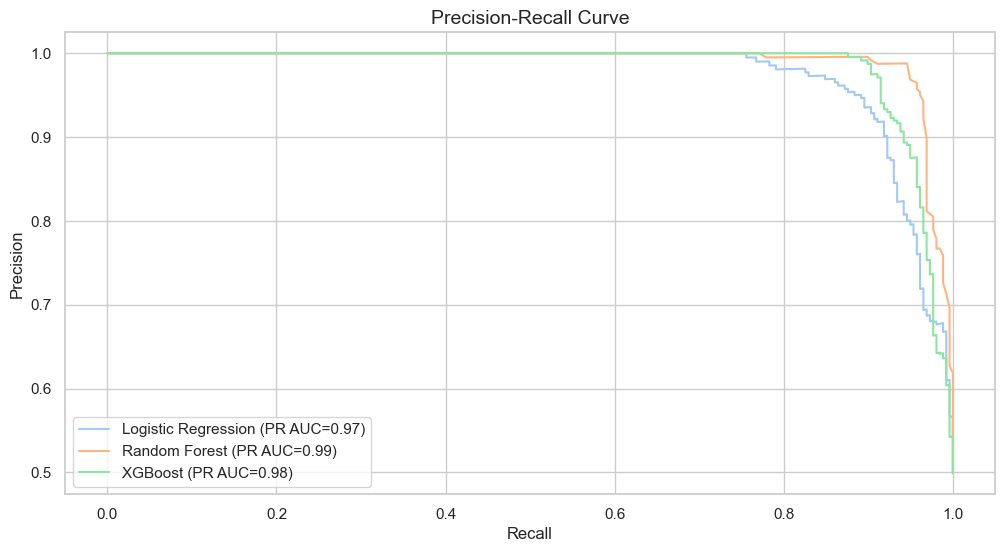

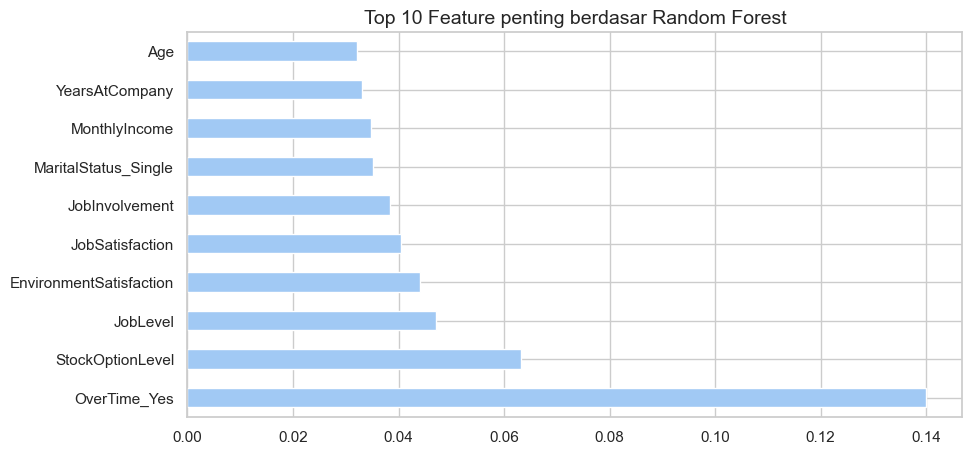

['modelprediksi.pkl']

In [ ]:
import joblib

# Modeling & Evaluasi 
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\nModel: {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("F1 Score:", f1_score(y_test, y_pred))

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print("PR AUC:", pr_auc)

    plt.plot(recall, precision, label=f'{name} (PR AUC={pr_auc:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)

# Logistic Regression
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)
evaluate_model(logreg, X_test, y_test, "Logistic Regression")

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest")

# XGBoost
xgb = XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_test, y_test, "XGBoost")

# Feature Importance 
feat_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
feat_importance.plot(kind='barh')
plt.title("Top 10 Feature penting berdasar Random Forest")
plt.show()


# Simpan model Random Forest sebagai model utama
joblib.dump(rf, "modelprediksi.pkl")

### Pemodelan, Evaluasi, dan Interpretasi

Pada tahap ini dilakukan pelatihan dan evaluasi beberapa model machine learning untuk memprediksi kemungkinan seorang karyawan keluar dari perusahaan (`Attrition`). Berikut ringkasan proses:

#### Model yang Digunakan:
1. **Logistic Regression**  
   Model linear sebagai baseline dengan `class_weight='balanced'` untuk mengatasi ketidakseimbangan kelas.

2. **Random Forest Classifier**  
   Model ensemble berbasis pohon keputusan dengan 100 estimator, juga menggunakan penyesuaian class weight.

3. **XGBoost Classifier**  
   Model boosting yang kuat dengan parameter `scale_pos_weight=1` dan metrik evaluasi `logloss`.

#### Evaluasi Performa:
- **Confusion Matrix** dan **Classification Report** (Accuracy, Precision, Recall, F1-Score).
- **ROC AUC Score** untuk mengukur kemampuan model dalam membedakan dua kelas.
- **Precision-Recall AUC (PR AUC)** untuk mengukur trade-off antara presisi dan recall, terutama berguna saat data tidak seimbang.
- Setiap model divisualisasikan menggunakan **Precision-Recall Curve**.

#### Hasil dari Data: 
1. Logistic Regression
- Akurasi: 92%
Confusion Matrix:
- 243 benar prediksi bertahan (True Negative)
- 233 benar prediksi keluar (True Positive)
- 25 salah prediksi bertahan → keluar (False Negative)
- 16 salah prediksi keluar → bertahan (False Positive)
- Precision (1): 94% → dari semua yang diprediksi keluar, 94% benar-benar keluar
- Recall (1): 90% → dari semua yang benar-benar keluar, 90% berhasil dikenali
- ROC AUC: 0.967 → sangat baik dalam memisahkan dua kelas
- PR AUC: 0.974 → konsisten bagus walau data imbalanced
- Logistic Regression sudah cukup baik, seimbang antara presisi dan recall.
- Masih ada 25 karyawan keluar yang tidak terdeteksi.

2. Random Forest
- Akurasi: 97% → paling tinggi
- Confusion Matrix:
- FN: 14 → paling sedikit
- FP: 3 → hampir tidak ada prediksi salah
- Precision (1): 99%, Recall (1): 95%
- F1 Score: 0.966 → model sangat stabil dan presisi tinggi
- ROC AUC: 0.987
- PR AUC: 0.990
- Random Forest adalah model terbaik di antara ketiganya, dengan keseimbangan akurasi, recall, dan presisi yang sangat tinggi.
- False Negative dan False Positive sangat rendah.

3. XGBoost
- Akurasi: 94%
- Confusion Matrix:
- FN: 22
- FP: 9
- Precision (1): 96%, Recall (1): 91%
- ROC AUC: 0.976, PR AUC: 0.983
- Masih sangat baik, meskipun sedikit menurun dibanding Random Forest.
- Lebih banyak False Negative (karyawan keluar yang tidak terdeteksi) dibanding Random Forest.

4. Random Forest memberikan performa terbaik secara keseluruhan dan layak dipilih sebagai model utama.
5. Logistic Regression cocok jika dibutuhkan model sederhana dan mudah dijelaskan ke manajemen.
6. XGBoost bagus tapi kalah tipis dari Random Forest dalam hal FN.


#### Interpretasi Model:
- Dihitung **Feature Importance** dari model Random Forest untuk mengetahui fitur-fitur terpenting dalam prediksi.
- Ditampilkan **10 fitur teratas** yang paling berpengaruh dalam memprediksi attrition.

#### Penyimpanan Model:
Model Random Forest disimpan dalam format `.pkl` menggunakan `joblib` dengan nama file `modelprediksi.pkl`. Model ini dapat digunakan kembali untuk prediksi di aplikasi dashboard atau backend.



In [82]:
# Bagian untuk prediksi probabilitas
# Membuat DataFrame untuk menyimpan probabilitas prediksi
predicted_proba = pd.DataFrame({
    'Prob_Attrition': rf.predict_proba(X_test)[:, 1],
    'True_Label': y_test.reset_index(drop=True)
})

print(predicted_proba.head())
predicted_proba.to_csv("prediksi_probabilitas.csv", index=False)


   Prob_Attrition  True_Label
0            0.98           1
1            0.79           1
2            0.97           1
3            0.90           1
4            0.09           0


In [ ]:
import joblib

# Fungsi prediksi peluang attrition
def cek_peluang_attrisi(input_data):
    # Pastikan input_data adalah DataFrame dengan urutan dan nama kolom sama seperti X_train/X_test
    model = joblib.load("modelprediksi.pkl")
    proba = model.predict_proba(input_data)[:, 1]
    pred = model.predict(input_data)
    return pred[0], proba[0]

# Contoh data input untuk pengecekan (diisi sesuai urutan kolom yang ada pada xtrain/X_test)
# input_dict sesuai urutan dan nama kolom df_encoded (tanpa kolom 'Attrition')
input_dict = {
    'Age': 24,
    'DailyRate': 588,
    'DistanceFromHome': 8,
    'Education': 2,
    'EnvironmentSatisfaction': 1,
    'HourlyRate': 65,
    'JobInvolvement': 2,
    'JobLevel': 2,
    'JobSatisfaction': 2,
    'MonthlyIncome': 5228,
    'MonthlyRate': 24624,
    'NumCompaniesWorked': 1,
    'PercentSalaryHike': 11,
    'PerformanceRating': 3,
    'RelationshipSatisfaction': 4,
    'StockOptionLevel': 1,
    'TotalWorkingYears': 13,
    'TrainingTimesLastYear': 2,
    'WorkLifeBalance': 3,
    'YearsAtCompany': 13,
    'YearsInCurrentRole': 12,
    'YearsSinceLastPromotion': 11,
    'YearsWithCurrManager': 9,
    # One-hot encoding kolom kategorikal
    'BusinessTravel_Travel_Frequently': False,
    'BusinessTravel_Travel_Rarely': True,
    'Department_Research & Development': False,
    'Department_Sales': True,
    'EducationField_Life Sciences': False,
    'EducationField_Marketing': False,
    'EducationField_Medical': False,
    'EducationField_Other': False,
    'EducationField_Technical Degree': True,
    'Gender_Male': False,
    'JobRole_Human Resources': False,
    'JobRole_Laboratory Technician': False,
    'JobRole_Manager': False,
    'JobRole_Manufacturing Director': False,
    'JobRole_Research Director': False,
    'JobRole_Research Scientist': False,
    'JobRole_Sales Executive': True,
    'JobRole_Sales Representative': False,
    'MaritalStatus_Married': True,
    'MaritalStatus_Single': False,
    'OverTime_Yes': True
}

import pandas as pd
input_df = pd.DataFrame([input_dict])

prediksi, peluang = cek_peluang_attrisi(input_df)
print(f"Prediksi: {'Keluar' if prediksi==1 else 'Bertahan'}")

print(f"Confidence attrition: {peluang*100:.2f}%")

Prediksi: Bertahan
Confidence attrition: 45.00%


### Fungsi Prediksi Peluang Attrition

Fungsi `cek_peluang_attrisi` digunakan untuk memprediksi apakah seorang karyawan akan keluar (attrition) atau tetap bertahan, berdasarkan input data individual.

#### Mekanisme Kerja:
- **Model yang digunakan**: Random Forest (`modelprediksi.pkl`), telah dilatih sebelumnya dan disimpan menggunakan `joblib`.
- **Input**: Satu baris data (DataFrame) yang harus memiliki struktur dan nama kolom yang sama persis dengan data training (`X_train`).
- **Output**:
  - Label prediksi: `0` (Bertahan) atau `1` (Keluar)
  - Probabilitas keluar (`predict_proba`)

#### Contoh Penggunaan:
- Dicontohkan input seorang karyawan dengan umur 24 tahun, job level 2, jarak rumah 8 km, lembur aktif, dan sebagainya.
- Fitur kategorikal telah **di-one-hot encode** secara manual sesuai skema `df_encoded`.

#### Output:
- Menampilkan label prediksi (`Keluar` atau `Bertahan`)
- Menampilkan probabilitas/tingkat keyakinan model terhadap prediksi attrition

Fungsi ini sangat bermanfaat sebagai backend logika prediksi, misalnya dalam aplikasi **Streamlit, dashboard HR, atau API layanan prediksi karyawan keluar**.


## Evaluation

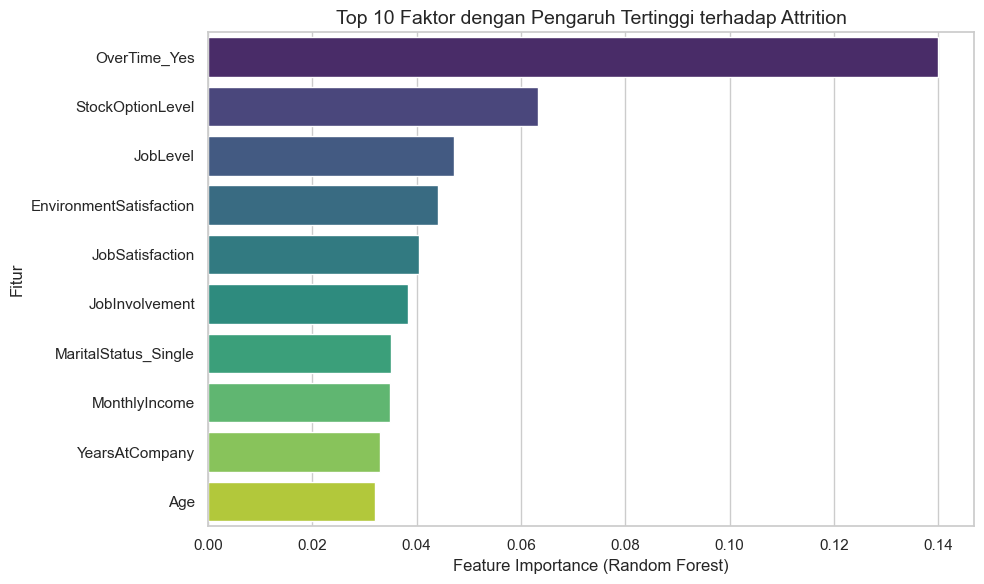

In [84]:
import joblib
import pandas as pd

import matplotlib.pyplot as plt

# Load model Random Forest yang sudah dilatih
rf = joblib.load("modelprediksi.pkl")

# Ambil nama fitur dari df_encoded (pastikan urutan sama dengan model)
feature_names = df_encoded.drop(columns='Attrition').columns

# Ambil nilai feature importance
importances = rf.feature_importances_

# Buat DataFrame untuk kemudahan visualisasi
feat_imp_df = pd.DataFrame({
    "Fitur": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot 10 faktor teratas yang paling berpengaruh terhadap attrition
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x="Importance", y="Fitur", palette="viridis")
plt.title("Top 10 Faktor dengan Pengaruh Tertinggi terhadap Attrition")
plt.xlabel("Feature Importance (Random Forest)")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

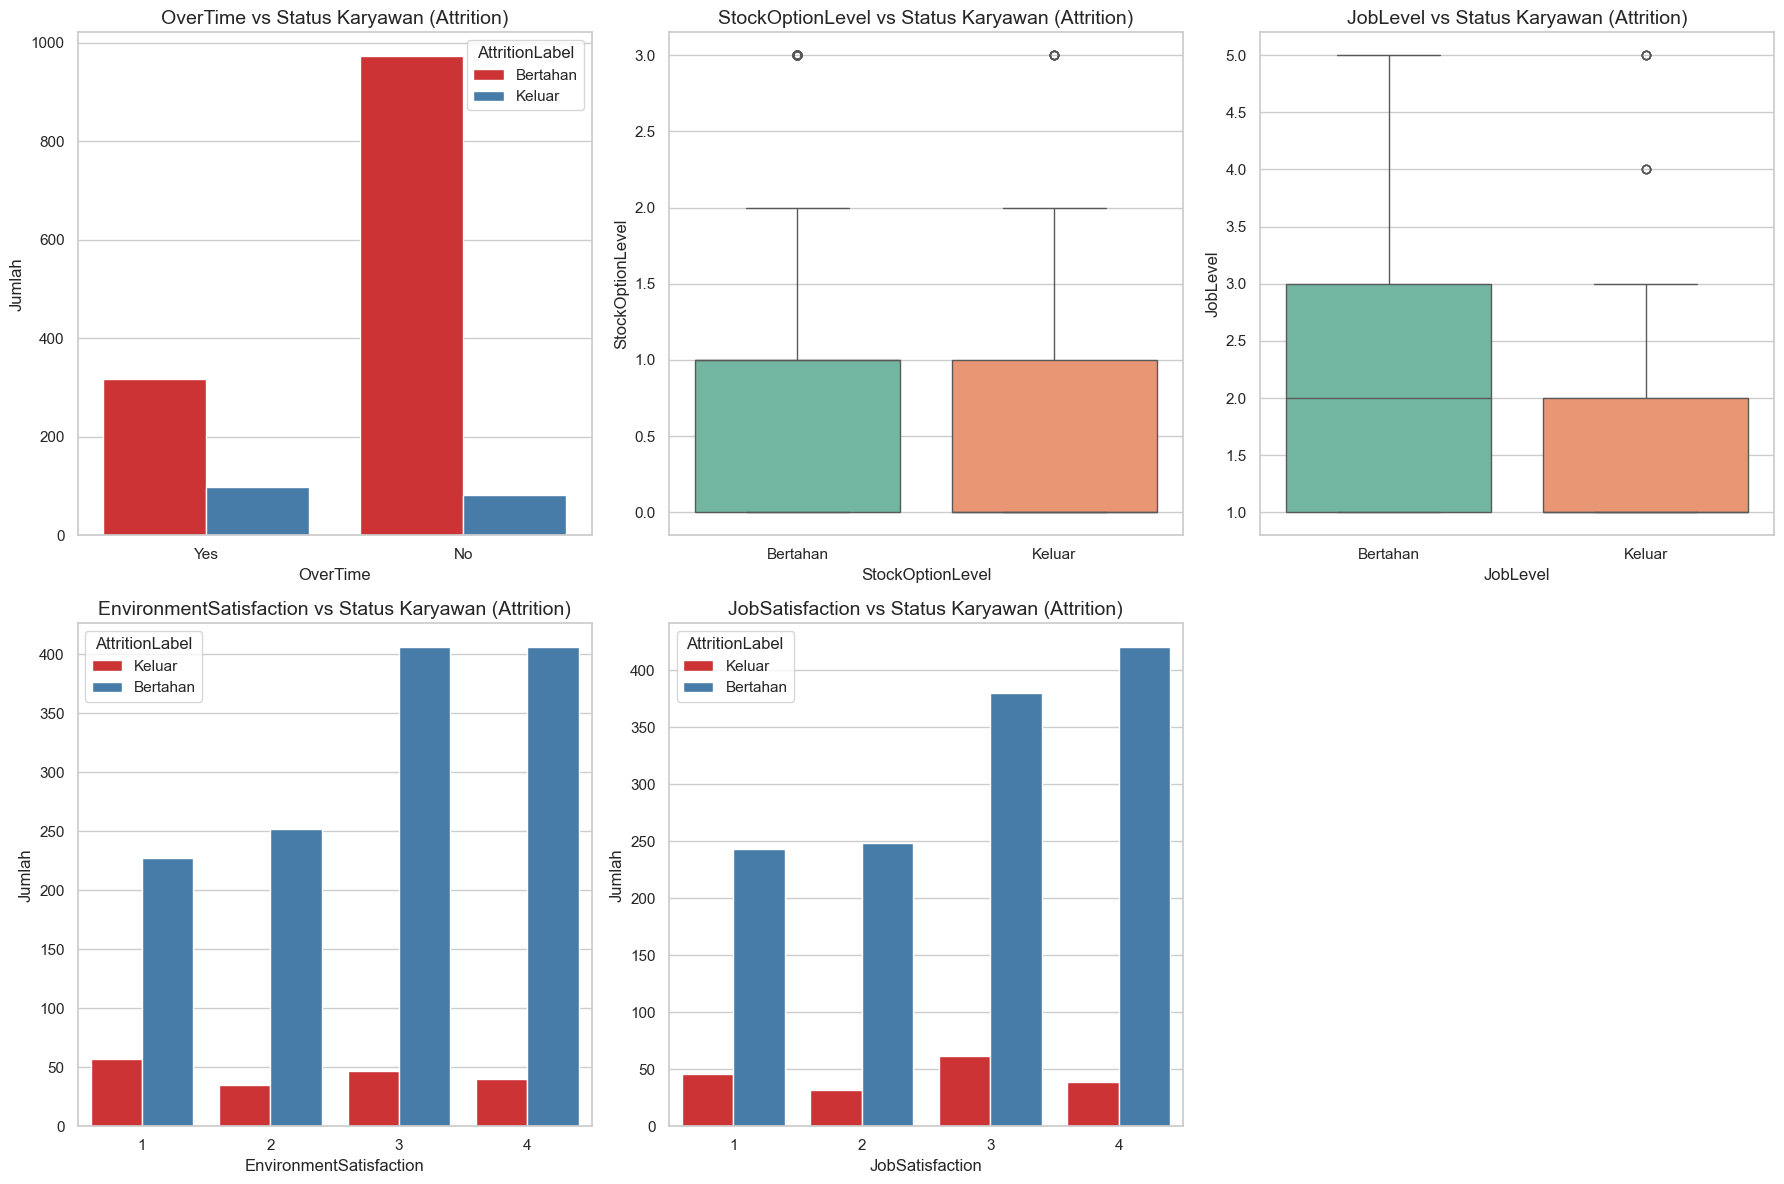


Distribusi 'OverTime' terhadap Attrition:
Attrition    0   1
OverTime          
No         973  81
Yes        318  98

Distribusi 'StockOptionLevel' terhadap Attrition:
Attrition           0    1
StockOptionLevel          
0                 510  121
1                 554   42
2                 150    8
3                  77    8

Distribusi 'JobLevel' terhadap Attrition:
Attrition    0    1
JobLevel           
1          435  108
2          497   37
3          193   25
4          102    4
5           64    5

Distribusi 'EnvironmentSatisfaction' terhadap Attrition:
Attrition                  0   1
EnvironmentSatisfaction         
1                        227  57
2                        252  35
3                        406  47
4                        406  40

Distribusi 'JobSatisfaction' terhadap Attrition:
Attrition          0   1
JobSatisfaction         
1                243  46
2                248  32
3                380  62
4                420  39


In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping label agar grafik mudah dipahami orang awam
attrition_map = {0: 'Bertahan', 1: 'Keluar'}
if 'Attrition' in dfc.columns and dfc['Attrition'].dtype in [int, float]:
    dfc['AttritionLabel'] = dfc['Attrition'].map(attrition_map)
else:
    dfc['AttritionLabel'] = dfc['Attrition']

# Kolom yang akan divisualisasikan
cols = ['OverTime', 'StockOptionLevel', 'JobLevel', 'EnvironmentSatisfaction', 'JobSatisfaction']

plt.figure(figsize=(18, 12))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    if col in ['StockOptionLevel', 'JobLevel']:
        # Boxplot untuk numerik vs target
        sns.boxplot(data=dfc, x='AttritionLabel', y=col, palette='Set2')
        plt.ylabel(col)
    else:
        # Countplot untuk kategori vs target
        sns.countplot(data=dfc, x=col, hue='AttritionLabel', palette='Set1')
        plt.ylabel('Jumlah')
    plt.title(f'{col} vs Status Karyawan (Attrition)')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Tampilkan angka jumlah masing-masing kategori pada fitur yang dipilih
for col in cols:
    print(f"\nDistribusi '{col}' terhadap Attrition:")
    print(dfc.groupby([col, 'Attrition']).size().unstack(fill_value=0))

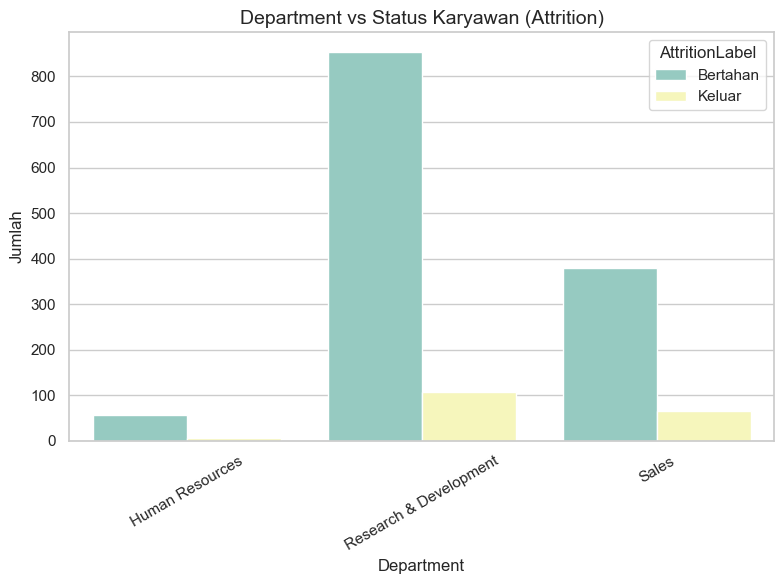


Distribusi 'Department' terhadap Attrition:
Attrition                 0    1
Department                      
Human Resources          57    6
Research & Development  854  107
Sales                   380   66

Persentase attrition (keluar) per Department terhadap total masing-masing departemen:
Department
Human Resources            9.52 %
Research & Development    11.13 %
Sales                      14.8 %
Name: Attrition, dtype: object


In [ ]:
# visualisasi untuk Department vs Attrition
plt.figure(figsize=(8, 6))
sns.countplot(data=dfc, x='Department', hue='AttritionLabel', palette='Set3')
plt.title('Department vs Status Karyawan (Attrition)')
plt.xlabel('Department')
plt.ylabel('Jumlah')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# angka jumlah masing-masing kategori pada Department
print("\nDistribusi 'Department' terhadap Attrition:")
print(dfc.groupby(['Department', 'Attrition']).size().unstack(fill_value=0))

# persentase attrisi (keluar) per Department
print("\nPersentase attrition (keluar) per Department terhadap total masing-masing departemen:")
dept_attrition = dfc.groupby('Department')['Attrition'].mean() * 100
print(dept_attrition.round(2).astype(str) + " %")

# Pengaruh Fitur Terhadap Attrition
## Evaluasi Attrition Berdasarkan Feature Importance (Random Forest)

### Berdasarkan hasil model **Random Forest**, berikut adalah fitur-fitur dengan pengaruh terbesar terhadap keputusan karyawan keluar dari perusahaan:

1. **OverTime_Yes** — Lembur menjadi faktor utama penyebab attrition.
2. **StockOptionLevel** — Kepemilikan opsi saham meningkatkan loyalitas.
3. **JobLevel** — Jabatan rendah lebih rentan terhadap turnover.
4. **EnvironmentSatisfaction** — Ketidakpuasan terhadap lingkungan kerja berdampak negatif.
5. **JobSatisfaction** — Kepuasan kerja rendah meningkatkan risiko keluar.
6. **JobInvolvement** — Kurangnya keterlibatan menurunkan engagement.
7. **MaritalStatus_Single** — Karyawan lajang memiliki potensi attrition lebih tinggi.
8. **MonthlyIncome** — Gaji bulanan memengaruhi keputusan bertahan.
9. **YearsAtCompany** — Masa kerja pendek lebih rentan keluar.
10. **Age** — Usia muda menunjukkan kecenderungan keluar lebih tinggi.


## Rekomendasi Action Items untuk Menurunkan Attrition
Berikut adalah daftar tindakan strategis berbasis data yang dapat diimplementasikan oleh HR dan manajemen Jaya Jaya Maju untuk mengurangi tingkat attrition:

### 1. Kendalikan Beban Lembur
- Evaluasi ulang kebijakan lembur.
- Buat batasan maksimal jam lembur per minggu.
- Implementasikan sistem monitoring beban kerja harian.

### 2. Optimalkan Program Opsi Saham
- Tinjau distribusi StockOptionLevel secara adil.
- Perluas akses opsi saham untuk karyawan berpotensi tinggi.
- Komunikasikan manfaat jangka panjang kepemilikan saham.

### 3. Kembangkan Jalur Karier yang Jelas
- Buat roadmap kenaikan jabatan berbasis kinerja.
- Sediakan program pelatihan & sertifikasi internal.
- Rotasi kerja untuk memperluas pengalaman antar-departemen.

### 4. Tingkatkan Kepuasan Kerja
- Lakukan survei kepuasan kerja minimal 2x setahun.
- Tindak lanjuti hasil survei dengan program perbaikan.
- Perkuat komunikasi dua arah antara manajemen dan karyawan.

### 5. Dorong Keterlibatan Karyawan
- Implementasi program penghargaan dan pengakuan (employee recognition).
- Bentuk tim proyek lintas fungsi (cross-functional taskforce).
- Dorong karyawan berpartisipasi dalam pengambilan keputusan operasional.

### 6. Fokus pada Karyawan Lajang & Usia Muda
- Tawarkan career coaching dan mentoring personal.
- Sediakan kegiatan sosial internal untuk meningkatkan sense of belonging.
- Ciptakan komunitas karyawan muda untuk saling mendukung.

### 7. Gunakan Dashboard Pemantauan Attrition
- Integrasikan model prediksi ke dalam dashboard HR.
- Tampilkan metrik risiko attrition untuk tiap segmen karyawan.
- Buat notifikasi dini untuk HR jika terdapat kenaikan risiko kelompok tertentu.


### Kesimpulan
Faktor-faktor yang berkaitan dengan **psikologi kerja dan keseimbangan hidup** memiliki dampak lebih signifikan terhadap keputusan keluar dibanding sekadar gaji. Intervensi yang tepat akan membantu perusahaan menurunkan tingkat attrition dan meningkatkan retensi jangka panjang.

